Analysis demo for Autoencoder with Constrained Latent (AE_CL) model on PDF toy moments

Brandon Kriesten (bkriesten@anl.gov),        T.J. Hobbs (tim@anl.gov)

In [1]:
#System path imports to find necessary directories
import os
import sys
latent_size = 32
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
outdata_dir = parent_dir+f'/output_data/vaim2_l{latent_size}_outputs'
indata_dir = parent_dir+f'/input_data/vaim2_l{latent_size}_data'
model_dir = parent_dir+'/vaim'
train_dir = parent_dir+f'/trained_models/vaim2_l{latent_size}_models'
sys.path.insert(1,outdata_dir)
sys.path.insert(2,model_dir)
sys.path.insert(3,indata_dir)

#Python numerical libraries
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import tensorflow as tf
import pickle
import lhapdf
from tqdm import tqdm

#Tensorflow Libraries
from tensorflow.keras import layers,losses,regularizers,optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

#Scipy Libraries
from scipy.special import gamma

#Keras Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Import model
from vaim import VAIM
from ensemble import Ensemble

In [2]:
#Pulls in all files necessary for analysis
xs = np.logspace(np.log10(1e-2),np.log10(0.999),196)

central_train = np.load(indata_dir+'/central_pdf_train.npy')
central_valid = np.load(indata_dir+'/central_pdf_valid.npy')
central_test = np.load(indata_dir+'/central_pdf_test.npy')

central_moments_train = np.load(indata_dir+'/moments_train.npy')
central_moments_valid = np.load(indata_dir+'/moments_valid.npy')
central_moments_test = np.load(indata_dir+'/moments_test.npy')

train = np.load(indata_dir+'/noisy_pdf_train.npy')
valid = np.load(indata_dir+'/noisy_pdf_valid.npy')
test = np.load(indata_dir+'/noisy_pdf_test.npy')

with open(indata_dir+'/pdf_scaler.pkl', 'rb') as f:
    sc = pickle.load(f)

with open(indata_dir+'/moment_scaler.pkl', 'rb') as g:
    moment_sc = pickle.load(g)

x_train = sc.transform(train)
x_valid = sc.transform(valid)
x_test = sc.transform(test)

y_train = moment_sc.transform(central_moments_train)
y_valid = moment_sc.transform(central_moments_valid)
y_test = moment_sc.transform(central_moments_test)

train_noise_array = np.load(indata_dir+'/pdf_noise_train.npy')
valid_noise_array = np.load(indata_dir+'/pdf_noise_valid.npy')
test_noise_array = np.load(indata_dir+'/pdf_noise_test.npy')

We implement a toy parametrization for PDFs, parametrizing the singlet and non-singlet distributions and flavor separated between $u$ and $d$ quarks.

$ f^{q}(x)_{+,-} = \mathcal{N} x^{\alpha} (1-x)^{\beta}(1+\gamma \sqrt{x} + \delta x)$

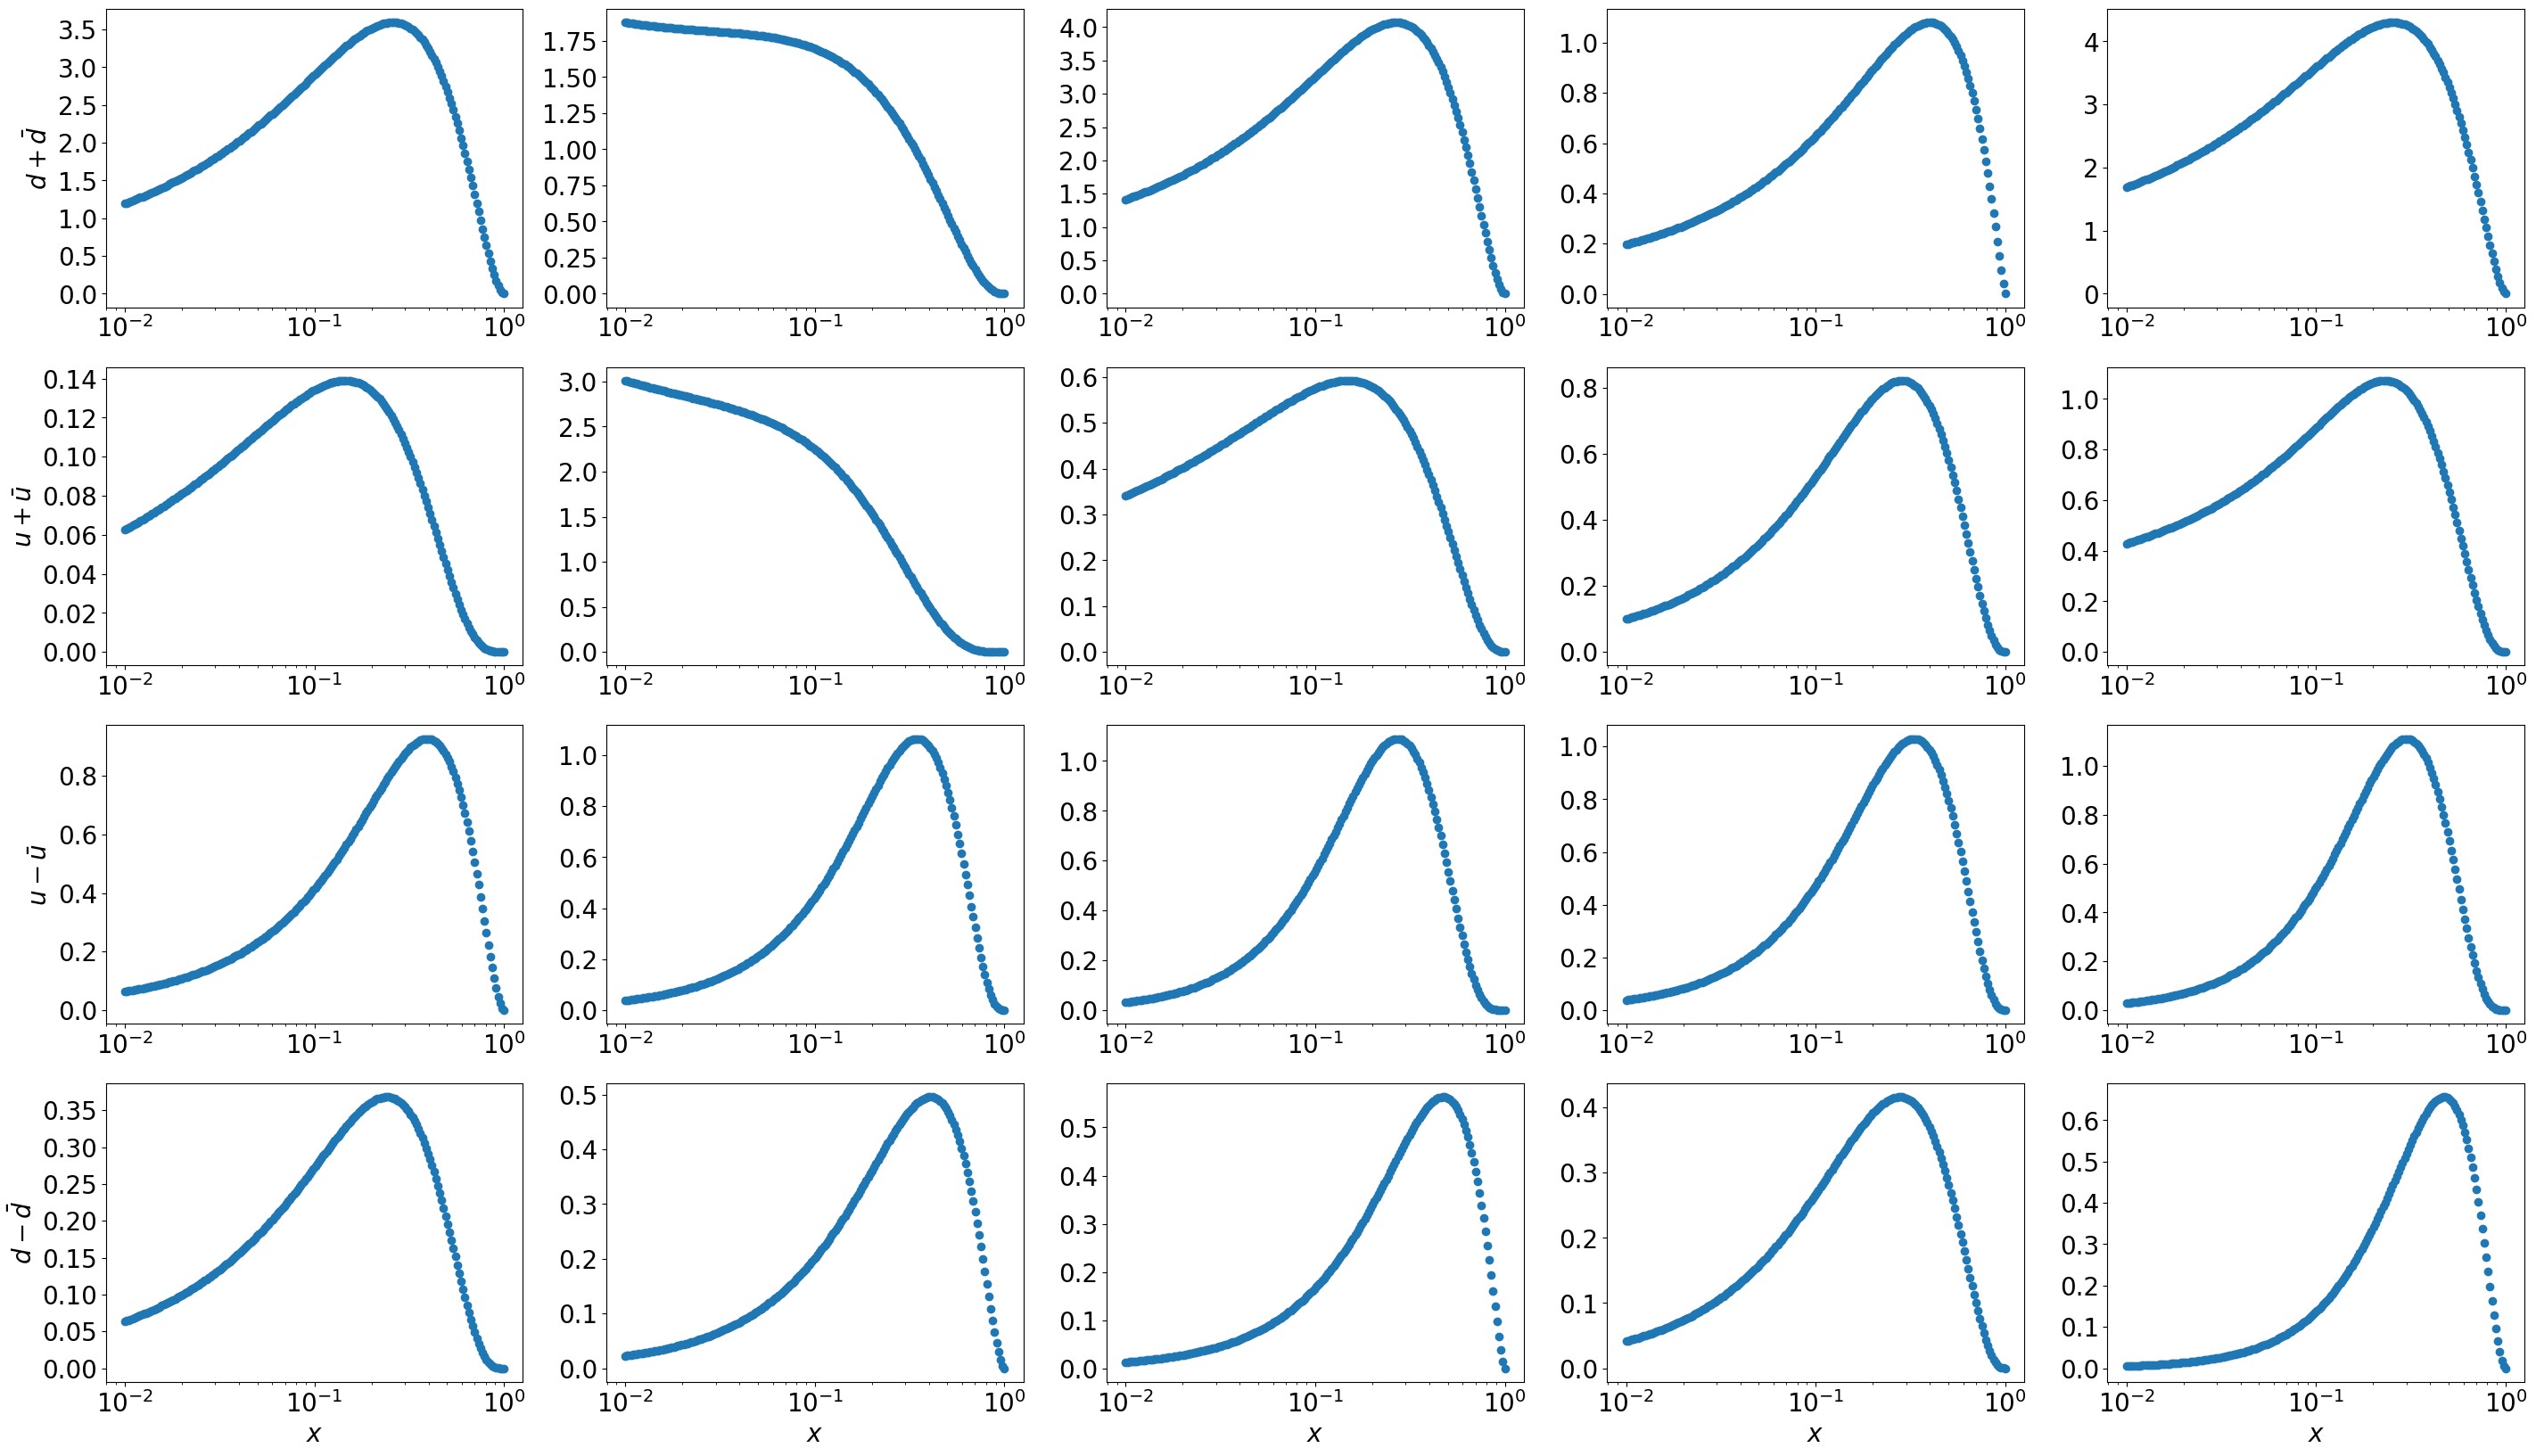

In [3]:
num_examples = 5
fig,ax = plt.subplots(nrows=4,ncols=num_examples,figsize=(35,20))

for i in range(4):
    for j in range(num_examples):
        plt.subplot(4,num_examples,num_examples*i+j+1)
        if j ==0:
            if i == 0:
                plt.ylabel(r'$d + \bar{d}$',fontsize=20)
            elif i == 1:
                plt.ylabel(r'$u + \bar{u}$',fontsize=20)
            elif i == 2:
                plt.ylabel(r'$u - \bar{u}$',fontsize=20)
            elif i == 3:
                plt.ylabel(r'$d - \bar{d}$',fontsize=20)
        if i == 3:
            plt.xlabel(r'$x$',fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.scatter(xs,train[j].reshape(4,196)[i])
        plt.xscale('log')

In [4]:
#Ensemble the outputs of encoder and decoder networks (PDFs and moments respectively)
outputs = np.load(outdata_dir+f'/pdf_outputs_latent_{latent_size}.npy')
output_moments = np.load(outdata_dir+f'/moment_outputs_latent_{latent_size}.npy')

pdfs_trans = []
moments_trans = []

#Step by step transforming the PDFs and moments
for i in range(outputs.shape[0]):
    pdfs_trans.append(sc.inverse_transform(outputs[i,:,:]))
    moments_trans.append(moment_sc.inverse_transform(output_moments[i,:,:]))

pdfs_trans = np.array(pdfs_trans)
moments_trans = np.array(moments_trans)

#Mean and standard deviations of the PDFs and moments
output_mean = np.mean(pdfs_trans,axis=0)
output_std = np.std(pdfs_trans,axis=0)

output_moments_mean = np.mean(moments_trans,axis=0)
output_moments_std = np.std(moments_trans,axis=0)

In [5]:
#Reshaping PDF array into the 4 d+,u+,u-,d- contributions
pdfs = np.reshape(output_mean,(x_test.shape[0],4,196))
pdfs_std = np.reshape(output_std,(x_test.shape[0],4,196))

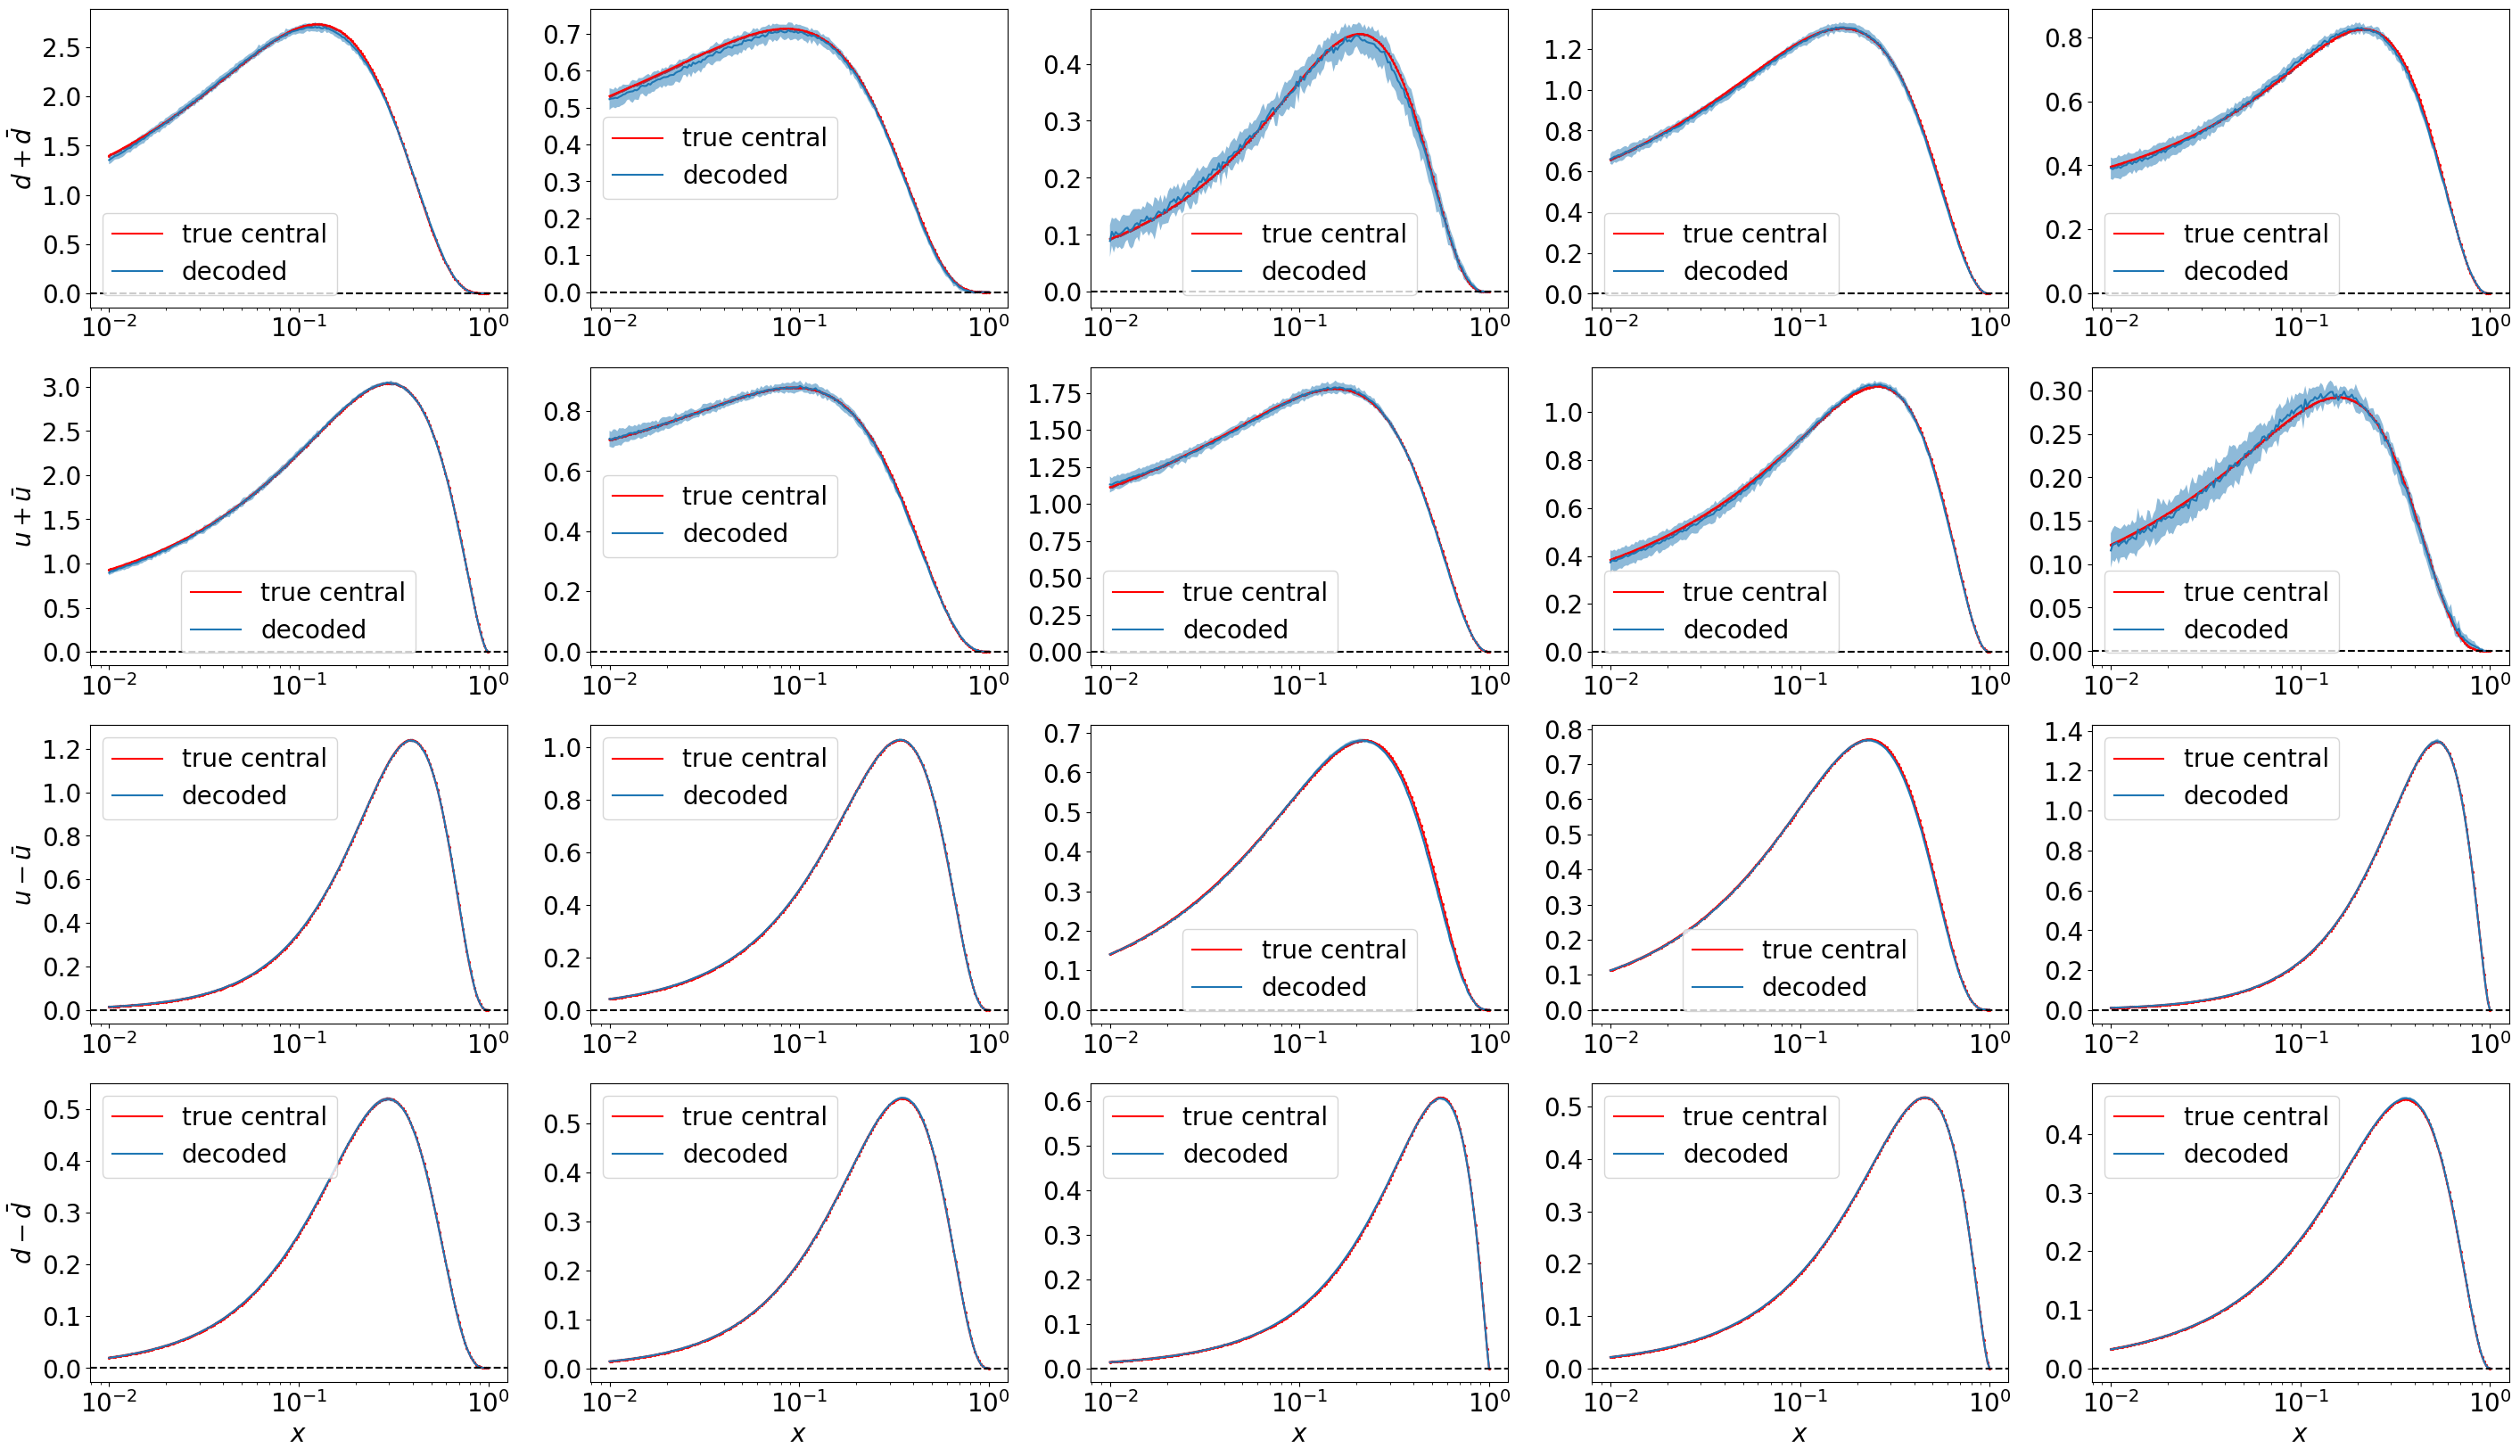

In [6]:
#Looking at the first 5 examples of the test set and comparing the output reconstructed PDF (blue)
#with the input distribution (red)
num_examples = 5
xs = np.logspace(-2,np.log10(0.999),196)

train_set = x_test
train_set = train_set
train_set = sc.inverse_transform(train_set)
train_set = train_set.reshape(x_test.shape[0],4,196)

fig,ax = plt.subplots(nrows=4,ncols=num_examples,figsize=(35,20))

for num in range(4):

    for j in range(num_examples):

        plt.subplot(4,num_examples,num_examples*num+j+1)
        
        if j ==0:
            if num == 0:
                plt.ylabel(r'$d + \bar{d}$',fontsize=20)
            elif num == 1:
                plt.ylabel(r'$u + \bar{u}$',fontsize=20)
            elif num == 2:
                plt.ylabel(r'$u - \bar{u}$',fontsize=20)
            elif num == 3:
                plt.ylabel(r'$d - \bar{d}$',fontsize=20)
        if num == 3:
            plt.xlabel(r'$x$',fontsize=20)
            
        plt.scatter(xs,train_set[j][num],color='red',s=1.75)
        plt.plot(xs,central_test.reshape(central_test.shape[0],4,196)[j][num],label='true central',color='red')
        plt.fill_between(xs,central_test.reshape(central_test.shape[0],4,196)[j][num] \
                         + test_noise_array.reshape(test_noise_array.shape[0],4,196)[j][num],\
                         central_test.reshape(central_test.shape[0],4,196)[j][num] \
                         - test_noise_array.reshape(test_noise_array.shape[0],4,196)[j][num],color='red',alpha=0.25)
        plt.plot(xs,pdfs[j][num],label='decoded')
        plt.fill_between(xs,pdfs[j][num]+ pdfs_std[j][num],pdfs[j][num]- pdfs_std[j][num],alpha=0.5)
        plt.xscale('log')
        plt.legend(loc='best',fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.axhline(0,lw=1.5,ls='--',color='black')

plt.show()


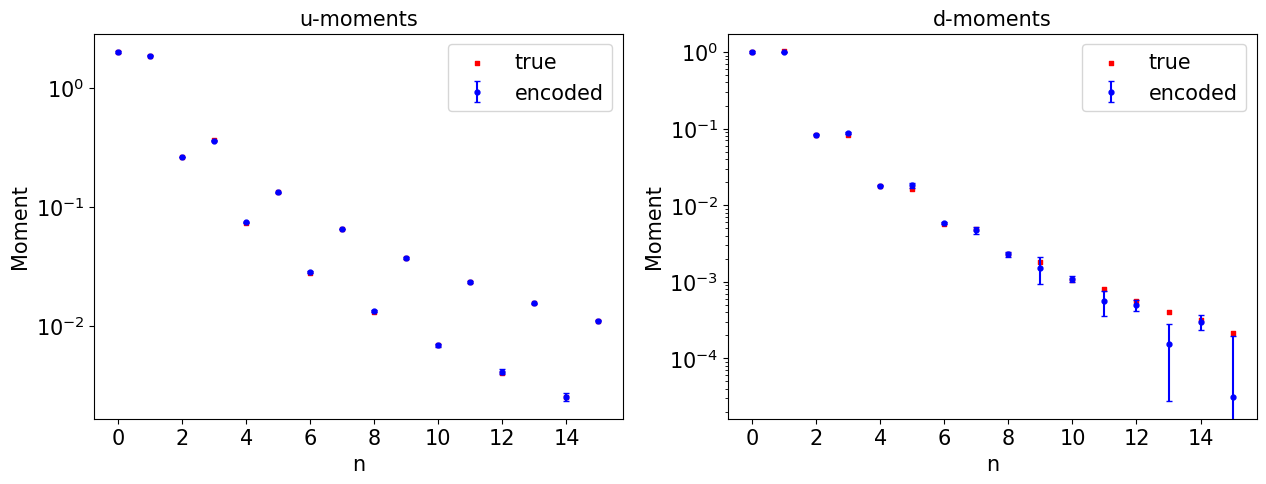

In [7]:
#Comparing how the test is encoded as compared to the true values of the moments
example_num = 0
u_indices = int(latent_size/2)
d_indices = int(latent_size/2)


fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
plt.subplot(1, 2, 1)
plt.errorbar(np.arange(0, len(output_moments_mean[example_num]))[:u_indices],
             output_moments_mean[example_num][:u_indices],
             output_moments_std[example_num][:u_indices],
             label='encoded',
             ls='None',
             color='blue',
             capsize=2,
             marker='o',
             markersize=3.5)
plt.scatter(np.arange(0, len(output_moments_mean[example_num]))[:u_indices],
            moment_sc.inverse_transform(y_test)[example_num][:u_indices],
            label='true',
            color='red',
            ls='None',
            marker='s',
            s=6.5)
ax[0].set_yscale('symlog', linthresh=1e-4)
plt.xlabel('n',fontsize=15)
plt.ylabel('Moment',fontsize=15)
plt.title('u-moments',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best',fontsize=15)

plt.subplot(1, 2, 2)
plt.errorbar(np.arange(0,len(output_moments_mean[example_num]))[:d_indices],
             output_moments_mean[example_num][d_indices:],
             output_moments_std[example_num][d_indices:],
             label='encoded',
             ls='None',
             color='blue',
             capsize=2,
             marker='o',
             markersize=3.5)
plt.scatter(np.arange(0,len(output_moments_mean[example_num]))[:d_indices],
            moment_sc.inverse_transform(y_test)[example_num][d_indices:],
            label='true',
            color='red',
            ls='None',
            marker='s',
            s=6.5)
plt.yscale('log')
plt.xlabel('n',fontsize=15)
plt.ylabel('Moment',fontsize=15)
plt.title('d-moments',fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()



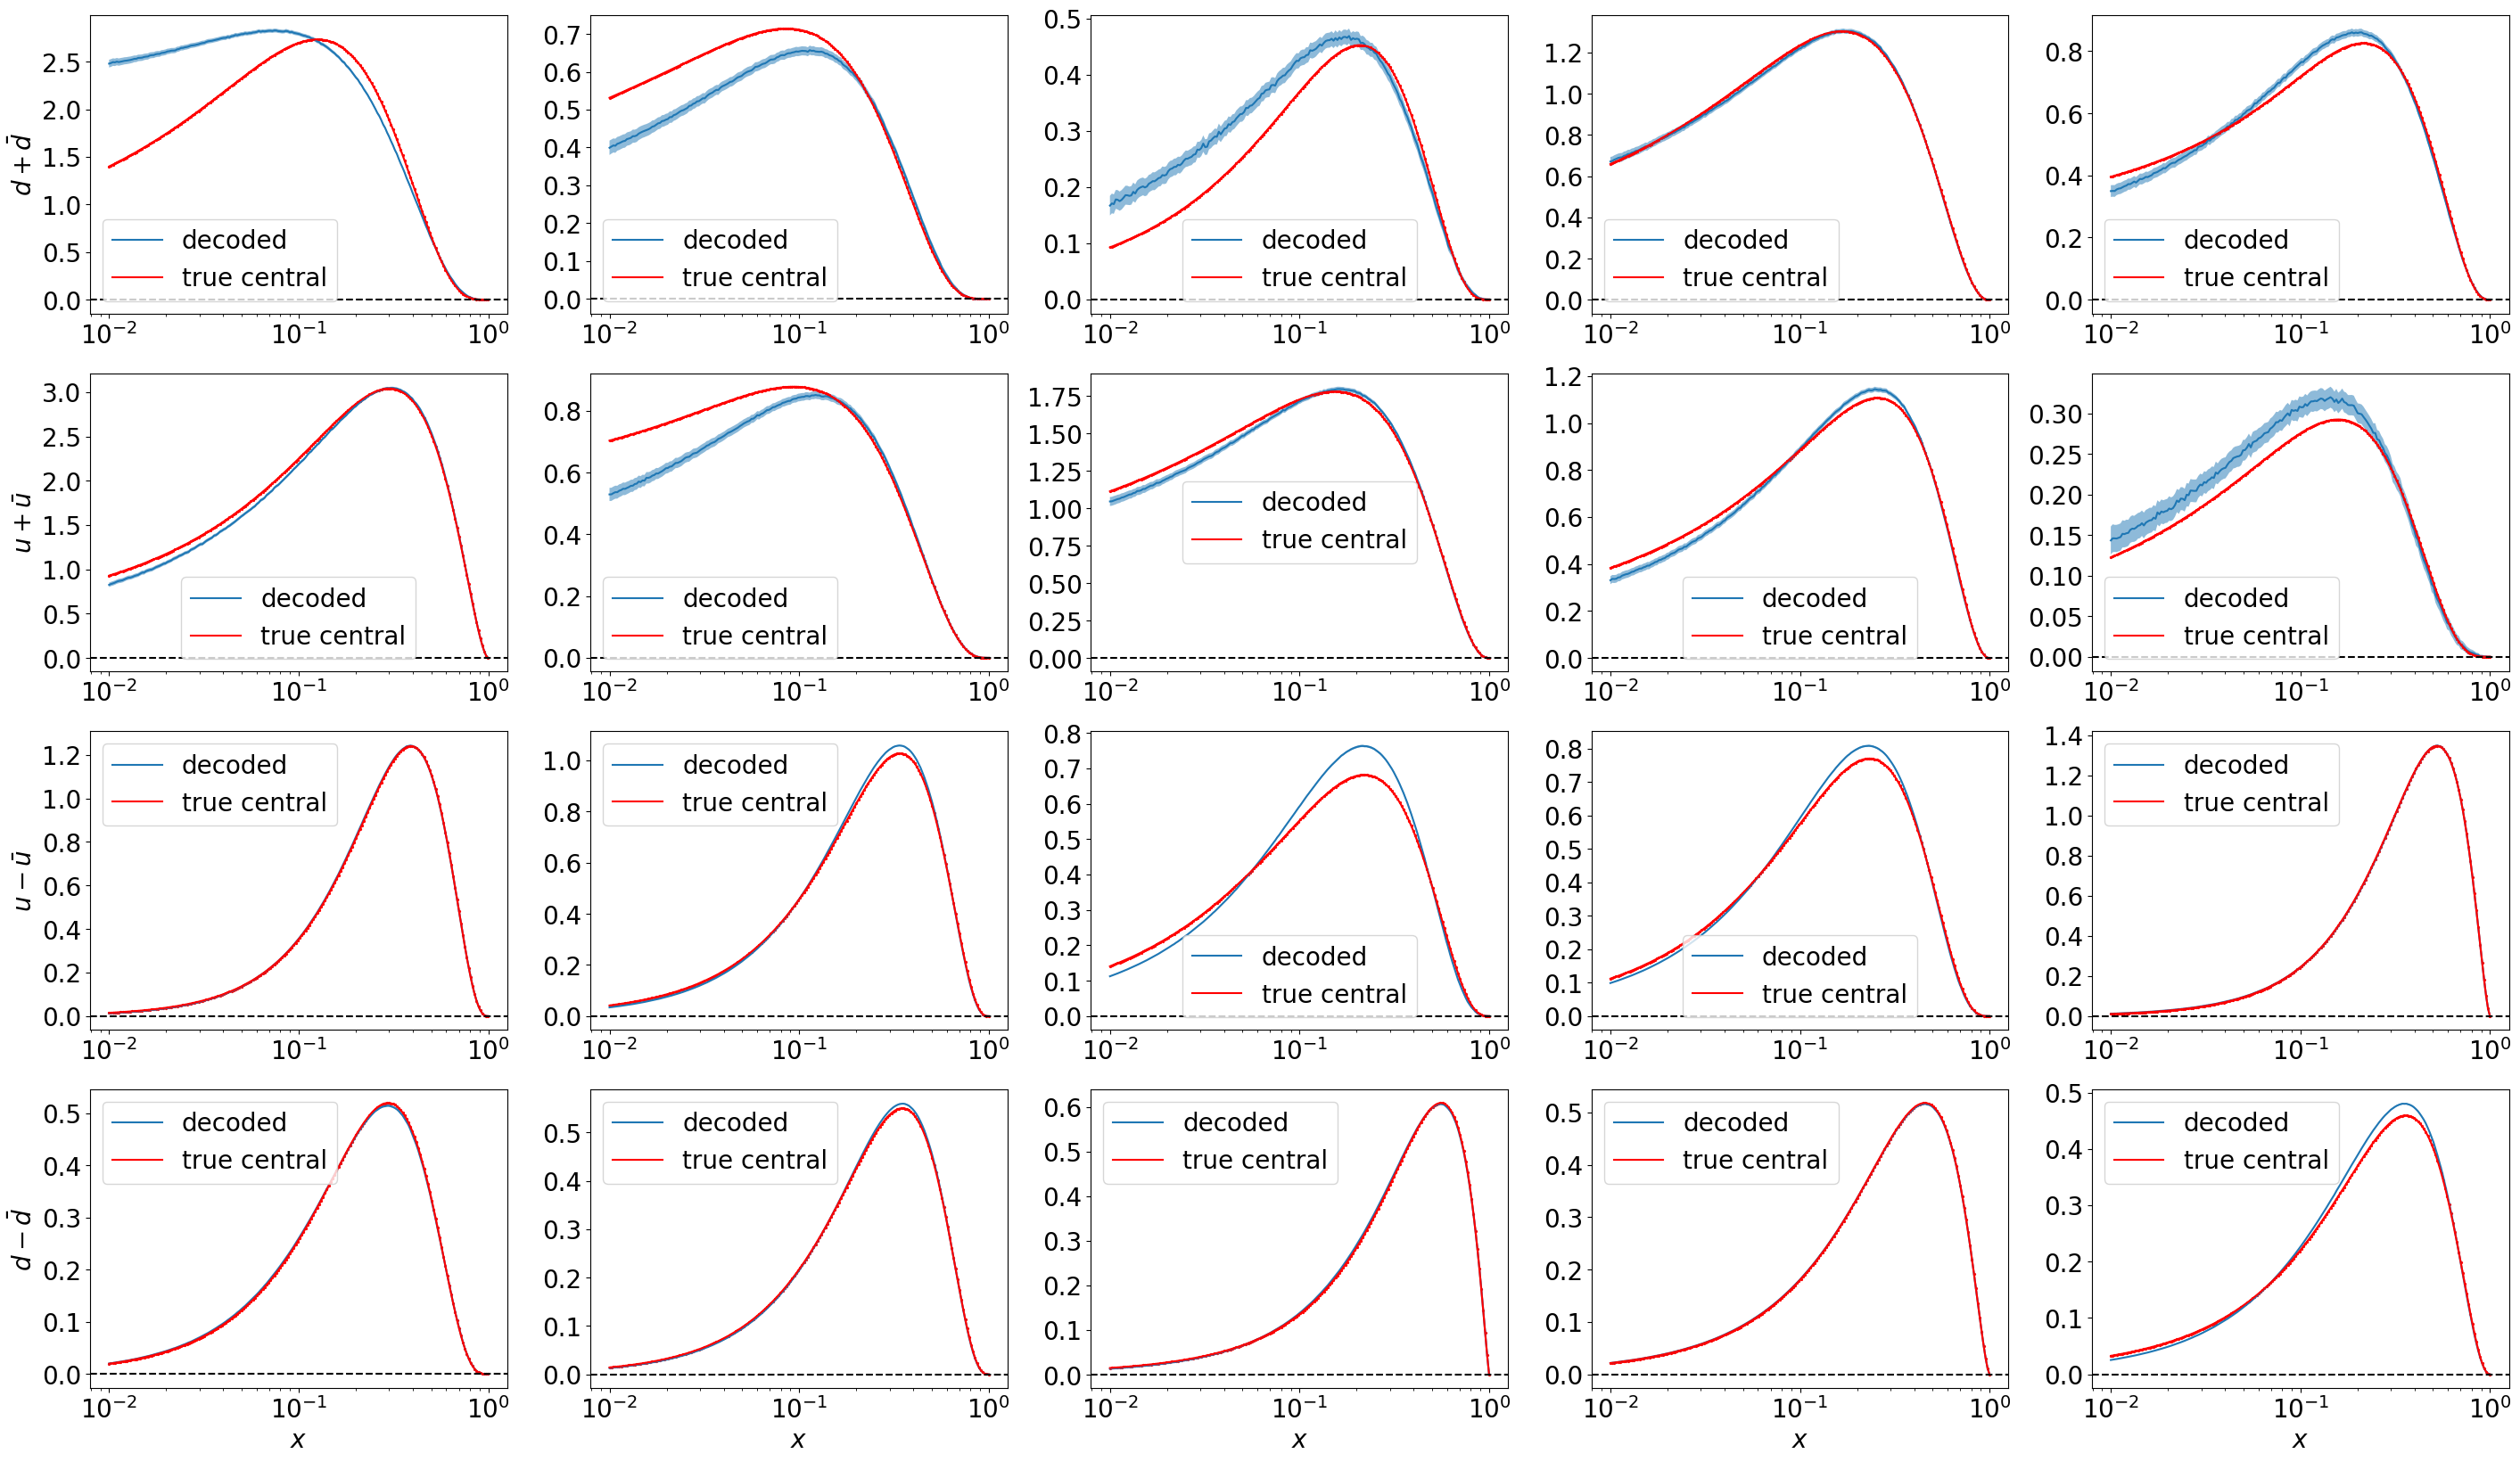

In [8]:
fig,ax = plt.subplots(nrows=4,ncols=5,figsize=(35,20))

for which_example in range(5):
    
    mean_pdf = []
    std_pdf = []

    for i in range(10):

        vae_ens = Ensemble(32)
        model = vae_ens.model
        model.build(x_test.shape)
        model.load_weights(train_dir+f'/model_{i}.hdf5')
        means, log_vars, _ , _ = model.encoder(x_test)

        mean = means[which_example]
        log_var = log_vars[which_example]

        z_sampling = np.random.uniform(mean,mean+np.sqrt(np.exp(log_var)),size=(10_000,32))

        moment = y_test[which_example].reshape(1,latent_size)
        moment_tile = np.tile(moment,(10_000,1))

        decoded = model.decoder([z_sampling,moment_tile])
        pdfs = sc.inverse_transform(decoded)
        pdf_mean = np.mean(pdfs,axis=0)
        pdf_std = np.std(pdfs,axis=0)
        mean_pdf.append(pdf_mean)
        std_pdf.append(pdf_std)
    
    mean_pdf = np.array(mean_pdf)
    std_pdf = np.array(std_pdf)

    pdf_mean = np.mean(mean_pdf,axis=0)
    pdf_std = np.mean(std_pdf,axis=0)
    
    for which_pdf in range(4):
        plt.subplot(4,5,5*which_pdf+which_example+1)

        if which_example ==0:
            if which_pdf == 0:
                plt.ylabel(r'$d + \bar{d}$',fontsize=20)
            elif which_pdf == 1:
                plt.ylabel(r'$u + \bar{u}$',fontsize=20)
            elif which_pdf == 2:
                plt.ylabel(r'$u - \bar{u}$',fontsize=20)
            elif which_pdf == 3:
                plt.ylabel(r'$d - \bar{d}$',fontsize=20)
        if which_pdf == 3:
            plt.xlabel(r'$x$',fontsize=20)
            
        plt.plot(xs,pdf_mean.reshape(4,196)[which_pdf],label='decoded')
        plt.fill_between(xs,pdf_mean.reshape(4,196)[which_pdf]+pdf_std.reshape(4,196)[which_pdf],
                         pdf_mean.reshape(4,196)[which_pdf]-pdf_std.reshape(4,196)[which_pdf],
                         alpha=0.5)
        plt.scatter(xs,train_set[which_example][which_pdf],color='red',s=1.75)
        plt.plot(xs,central_test.reshape(central_test.shape[0],4,196)[which_example][which_pdf],
                 label='true central',color='red')
        plt.fill_between(xs,central_test.reshape(central_test.shape[0],4,196)[which_example][which_pdf] \
                         + test_noise_array.reshape(test_noise_array.shape[0],4,196)[which_example][which_pdf],\
                         central_test.reshape(central_test.shape[0],4,196)[which_example][which_pdf] \
                         - test_noise_array.reshape(test_noise_array.shape[0],4,196)[which_example][which_pdf],
                         color='red',alpha=0.25)
        plt.xscale('log')
        plt.legend(loc='best',fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.axhline(0,lw=1.5,ls='--',color='black')

In [9]:
#Using the trained VAIM model, we wiggle the true moments within the error bands
#and use these inputs to construct output PDFs
vaim_ens = Ensemble(latent_size)
vaim = vaim_ens.model
vaim.build(input_shape=x_test.shape)

decoded_pdf_arr = []

for i in range(10):

  model_number = i
  vaim.load_weights(train_dir+f'/model_{model_number}.hdf5')

  y_test_wiggled = moment_sc.transform(moment_sc.inverse_transform(y_test) 
                                       + np.random.normal(loc=0,scale=output_moments_std))

  means, log_vars, _, _ = vaim.encoder(x_test)
  z_samples = np.random.uniform(means, means + np.sqrt(np.exp(log_vars)), size = (x_test.shape[0],32))

  decoded_pdfs = vaim.decoder([z_samples, y_test_wiggled]).numpy()
  decoded_pdfs = sc.inverse_transform(decoded_pdfs)
  decoded_pdfs = decoded_pdfs.reshape(decoded_pdfs.shape[0],4,196)

  decoded_pdf_arr.append(decoded_pdfs)

decoded_pdf_arr = np.array(decoded_pdf_arr)
decoded_pdf_mean = np.mean(decoded_pdf_arr,axis=0)
decoded_pdf_std = np.std(decoded_pdf_arr,axis=0)

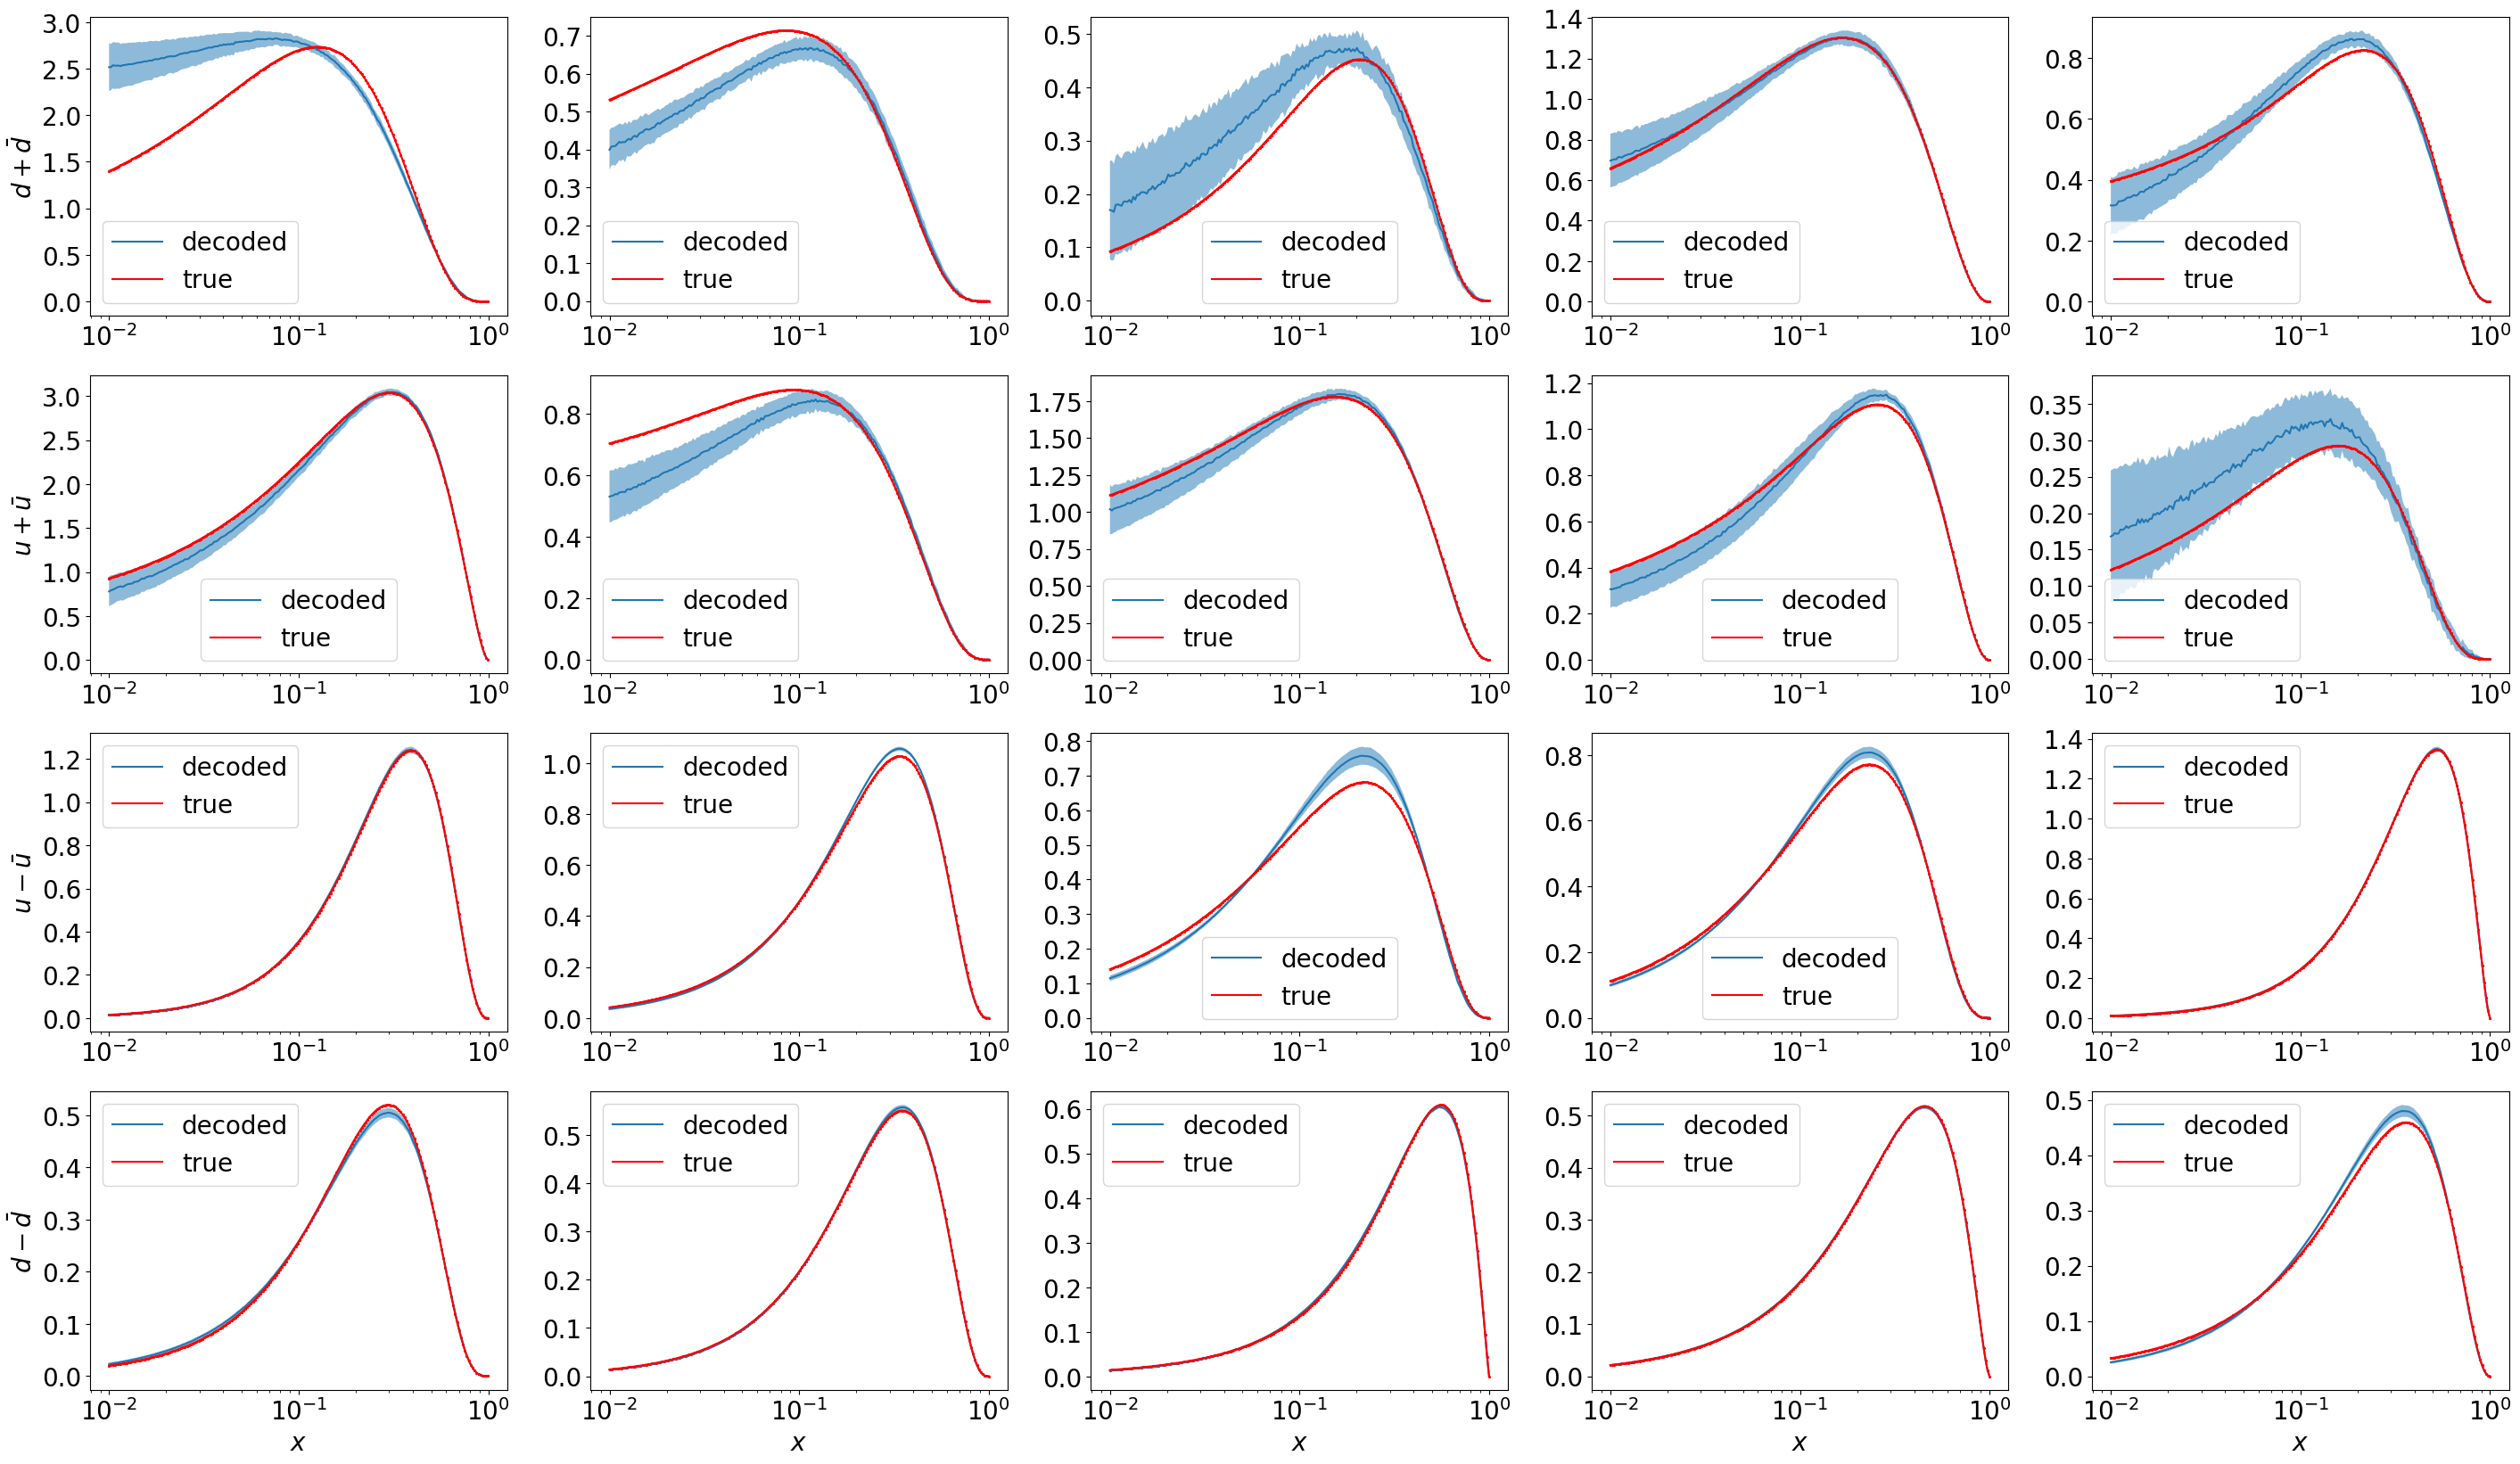

In [10]:
num_examples = 5

fig,ax = plt.subplots(nrows=4,ncols=num_examples,figsize=(35,20))

for i in range(4):
    for j in range(num_examples):
        plt.subplot(4,num_examples,num_examples*i+j+1)
        if j ==0:
            if i == 0:
                plt.ylabel(r'$d + \bar{d}$',fontsize=20)
            elif i == 1:
                plt.ylabel(r'$u + \bar{u}$',fontsize=20)
            elif i == 2:
                plt.ylabel(r'$u - \bar{u}$',fontsize=20)
            elif i == 3:
                plt.ylabel(r'$d - \bar{d}$',fontsize=20)
        if i == 3:
            plt.xlabel(r'$x$',fontsize=20)
        plt.plot(xs,decoded_pdf_mean[j][i],label='decoded')
        plt.fill_between(xs,decoded_pdf_mean[j][i]+decoded_pdf_std[j][i],
                         decoded_pdf_mean[j][i]-decoded_pdf_std[j][i],
                         alpha=0.5)
        plt.plot(xs,
                 central_test.reshape(central_test.shape[0],4,196)[j][i],
                 color='red',
                 label='true')
        plt.fill_between(xs,central_test.reshape(central_test.shape[0],4,196)[j][i] \
                         + test_noise_array.reshape(test_noise_array.shape[0],4,196)[j][i],\
                         central_test.reshape(central_test.shape[0],4,196)[j][i] \
                         - test_noise_array.reshape(test_noise_array.shape[0],4,196)[j][i],
                         color='red',alpha=0.25)
        plt.scatter(xs,train_set[j][i],color='red',s=1.75)
        plt.xscale('log')
        plt.legend(loc='best',fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
plt.show()


In [11]:
#Studying the Pearson correlations between the encoded latent variable (moment) and the 
#decoded PDF. The Pearson correlation is the correlations over the DECODER of the AE_CL model.
which_pdf = 0
num_replicas = 100_000
corr_arr = []

for example_num in tqdm(range(output_moments_mean.shape[0])):
    
    replica_encoded_moments = output_moments_mean[example_num]\
                        + np.random.normal(loc=0,scale=output_moments_std[example_num],
                                           size=(num_replicas,latent_size))
    means, log_vars, _, _ = vaim.encoder(x_test)
    z_sampling = np.random.uniform(means[example_num], 
                                   means[example_num] + np.sqrt(np.exp(log_vars[example_num])),
                                   size=(num_replicas, latent_size))
    
    replica_decoded_pdfs = sc.inverse_transform(
                            vaim.decoder([
                                z_sampling,
                                moment_sc.transform(
                                    replica_encoded_moments
                                )
                            ])).reshape(num_replicas,4,196)
    
    mean_example_moments = output_moments_mean[example_num]
    std_example_moments = output_moments_std[example_num]
    mean_decoded_pdfs = np.mean(replica_decoded_pdfs,axis=0)
    std_decoded_pdfs = np.std(replica_decoded_pdfs,axis=0)

    exp_xy = (replica_encoded_moments.T@replica_decoded_pdfs[:,which_pdf,:])/num_replicas

    exp_x = mean_decoded_pdfs[which_pdf]
    exp_x = exp_x.reshape(exp_x.shape[0],1)

    exp_y = mean_example_moments
    exp_y = exp_y.reshape(exp_y.shape[0],1)

    exp_x_exp_y = exp_x@exp_y.T
    exp_x_exp_y = exp_x_exp_y.T

    delta_x = replica_decoded_pdfs[:,which_pdf,:] - mean_decoded_pdfs[which_pdf]
    delta_x = np.sqrt(((1./(num_replicas-1.))*np.sum((delta_x**2),axis=0)))
    delta_x = delta_x.reshape(delta_x.shape[0],1)

    delta_y = replica_encoded_moments - mean_example_moments
    delta_y = np.sqrt(((1./(num_replicas-1.))*np.sum((delta_y**2),axis=0)))
    delta_y = delta_y.reshape(delta_y.shape[0],1)

    delta_x_delta_y = delta_y@delta_x.T

    corr_mc = (exp_xy - exp_x_exp_y )/ delta_x_delta_y
    corr_arr.append(corr_mc)

corr_arr = np.array(corr_arr)
corr_arr_mean = np.mean(corr_arr,axis=0)
corr_arr_std = np.std(corr_arr,axis=0)

100%|█████████████████████████████████████| 1500/1500 [2:01:07<00:00,  4.84s/it]


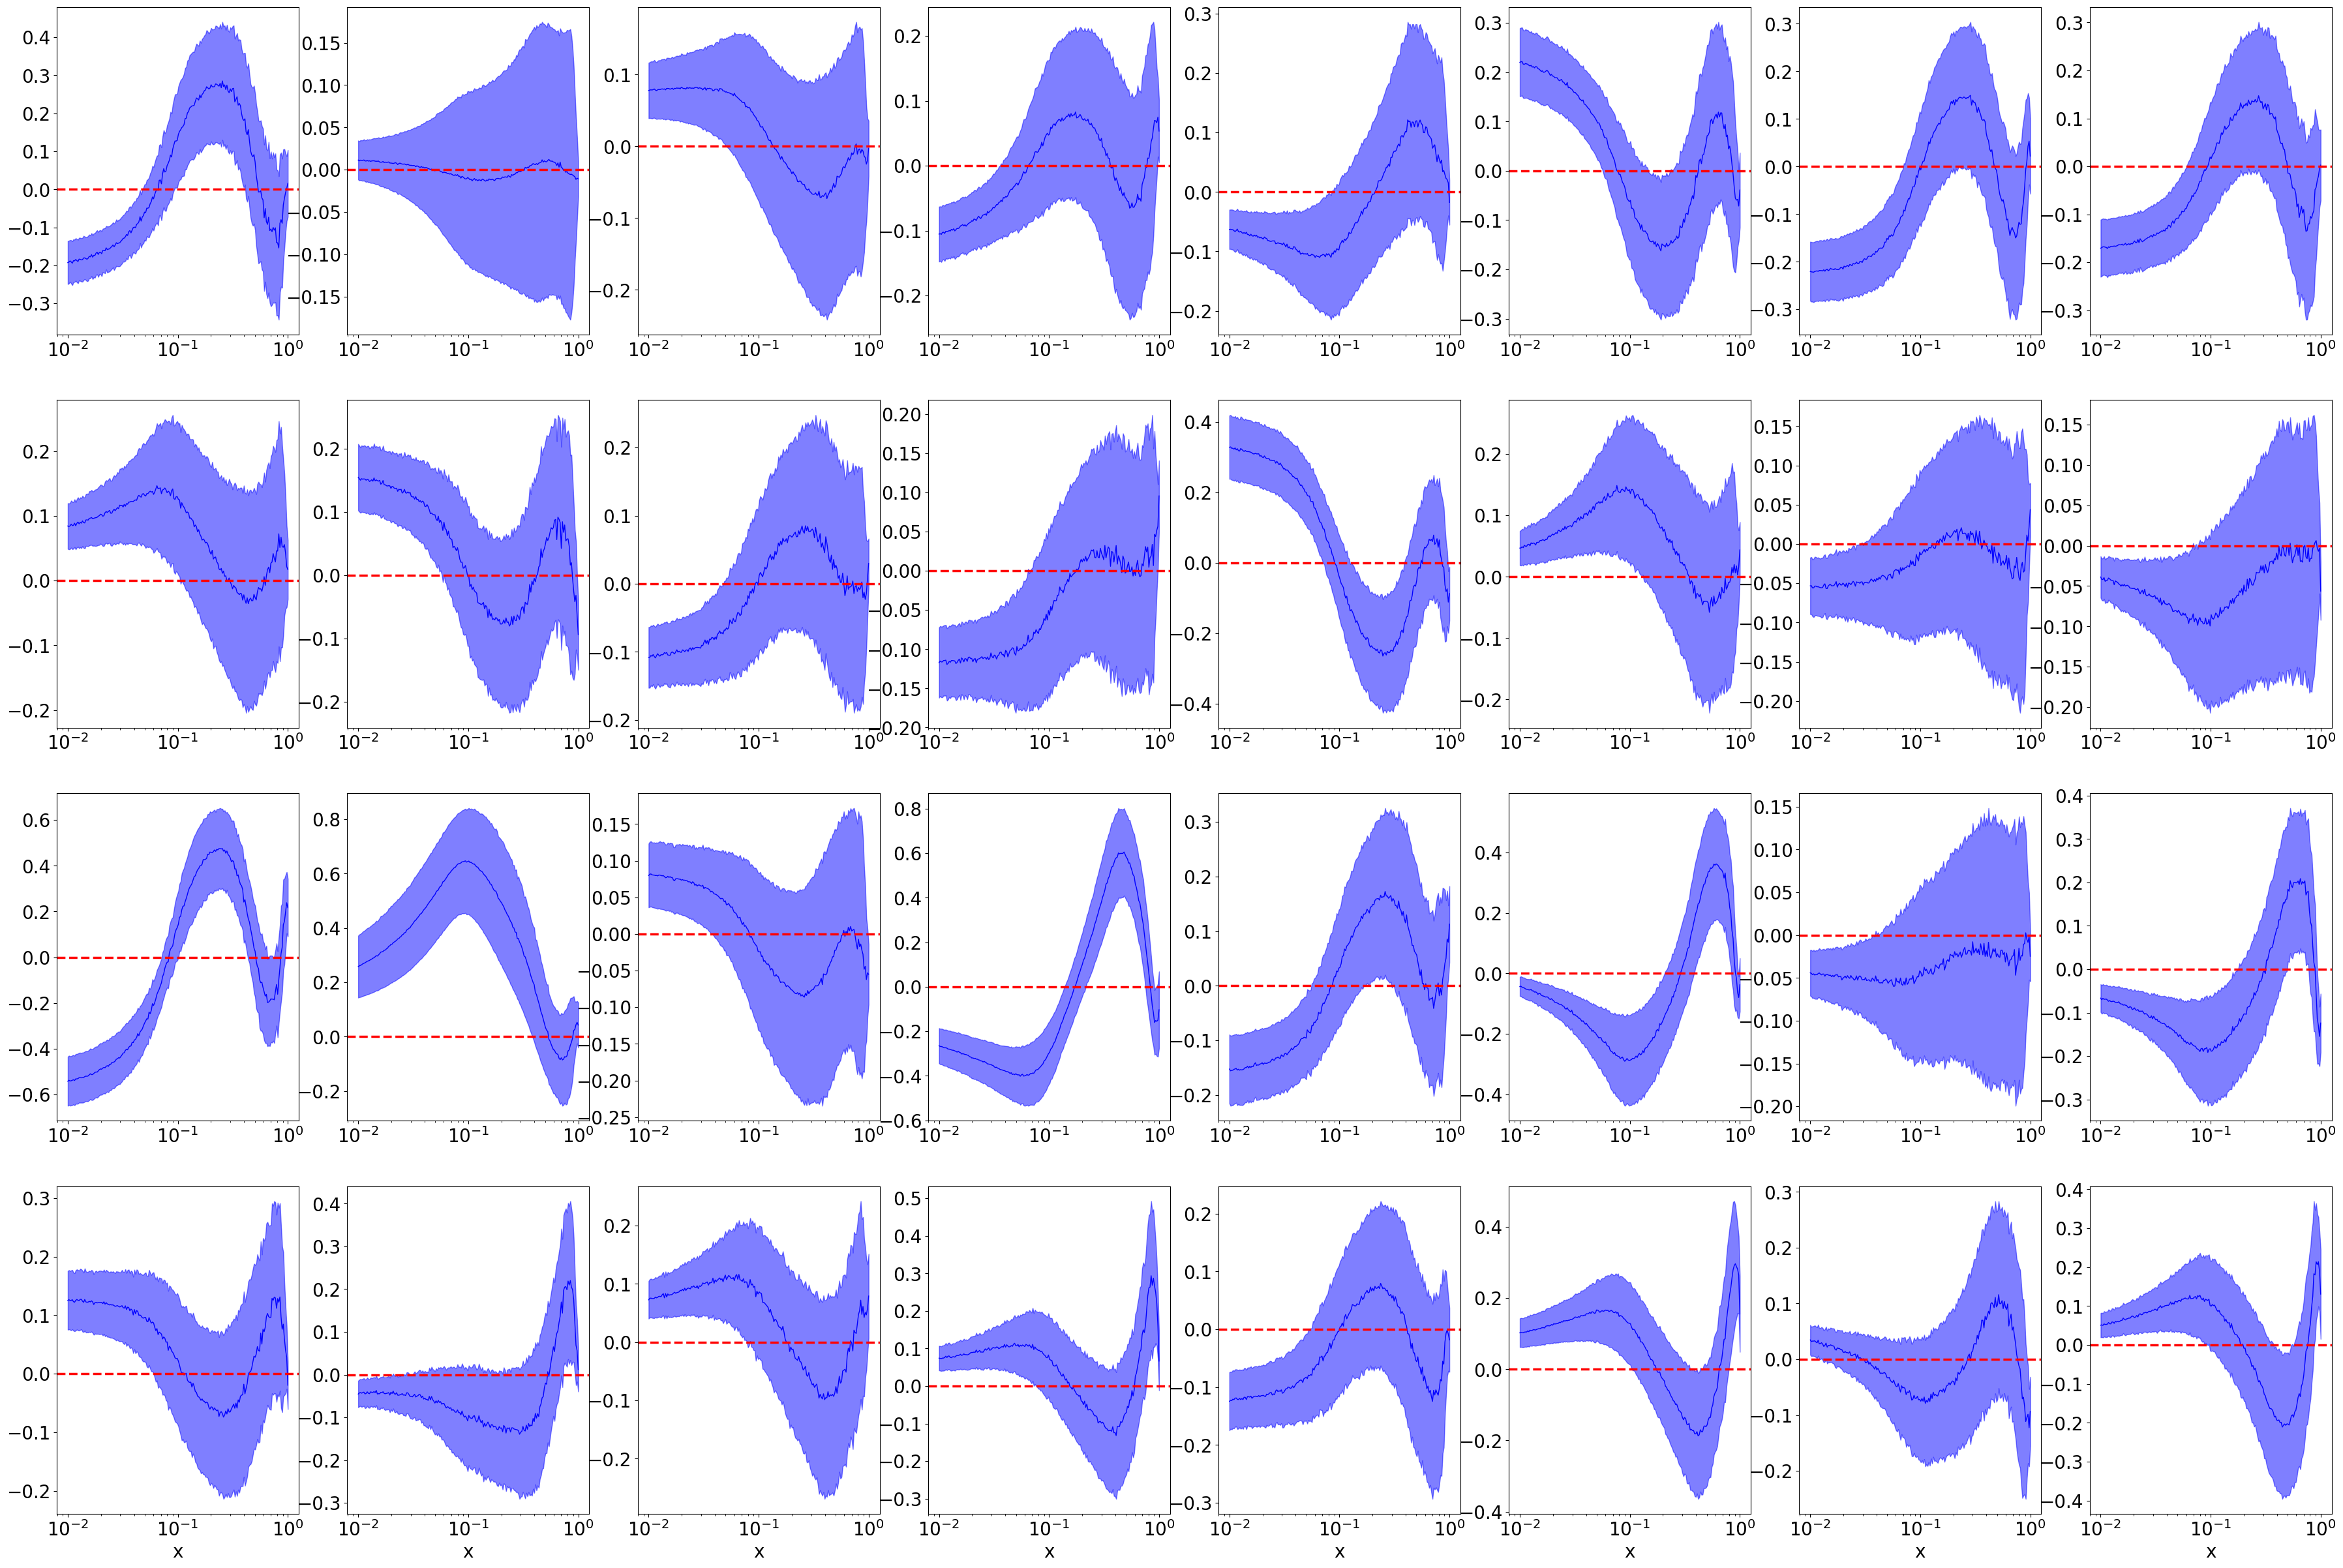

In [12]:
fig,ax = plt.subplots(nrows=4,ncols=8,figsize=(45,30))

for i in range(32):

    plt.subplot(4,8,i+1)
    plt.plot(xs,corr_arr_mean[i],color='blue',lw=1.)
    plt.fill_between(xs,corr_arr_mean[i] + corr_arr_std[i],
                     corr_arr_mean[i]-corr_arr_std[i],color='blue',alpha=0.5)
    plt.xscale('log')
    plt.axhline(y=0,color='red',linestyle='--',lw=2.5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if i >= 24:
        plt.xlabel('x',fontsize=20)

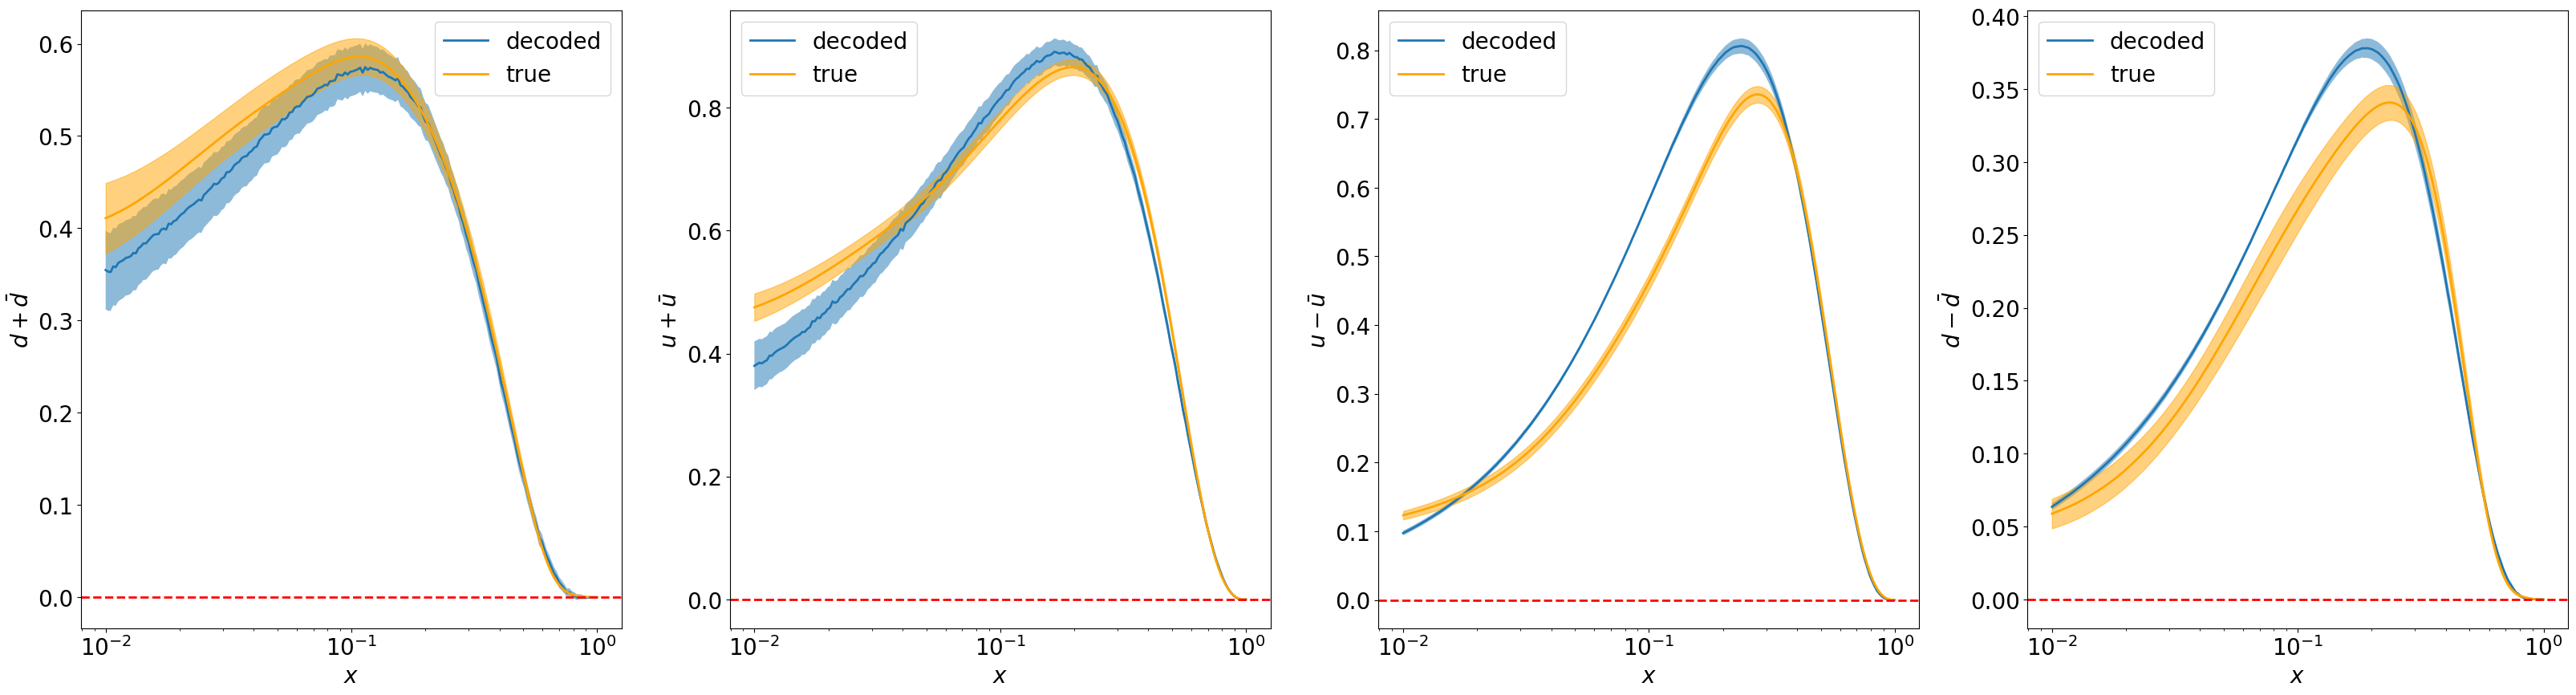

In [12]:
num_wiggles = 10_000

ct18nnlo_moments = np.load('msht20nnlo_moments.npy').reshape(1,32)
ct18nnlo_mom_std = np.load('msht20nnlo_moments_errors.npy').reshape(1,32)
ct18nnlo_moments_tiles = np.tile(ct18nnlo_moments,(num_wiggles,1))
ct18nnlo_moments_stds = np.tile(ct18nnlo_mom_std,(num_wiggles,1))

means = []
stds = []

for i in range(10):

    vaim_ens = Ensemble(32)
    vaim = vaim_ens.model
    vaim.build(x_test.shape)
    vaim.load_weights(train_dir+f'/model_{i}.hdf5')
    z_sampling = np.random.uniform(size=(num_wiggles,32))
    ct18_wiggled = moment_sc.transform(ct18nnlo_moments_tiles
                                       + np.random.normal(loc=0,scale=ct18nnlo_moments_stds))
    decoded = vaim.decoder([z_sampling,ct18_wiggled])
    decoded_trans = sc.inverse_transform(decoded)
    pdfs = decoded_trans.reshape(decoded_trans.shape[0],4,196)
    pdf_mean = np.mean(pdfs,axis=0)
    pdf_std = np.std(pdfs,axis=0)
    means.append(pdf_mean)
    stds.append(pdf_std)

means = np.array(means)
stds = np.array(stds)

pdf_mean = np.mean(means,axis=0)
pdf_std = np.mean(stds,axis=0)

q2 = 1.**2
xs = np.array([x for x in np.logspace(-2,np.log10(0.999),196)])

pset = lhapdf.getPDFSet("MSHT20nnlo_as118")
len_pset = len(pset)
num_replicas = len_pset - 1
pcentral = pset.mkPDF(0)
perrset = np.array([pset.mkPDF(i) for i in range(1,num_replicas+1)])
plus_eigens = np.array([perrset[i] for i in np.arange(0,num_replicas,2)])
minus_eigens = np.array([perrset[i] for i in np.arange(1,num_replicas,2)])

uplus_err = 0
uminus_err = 0
dplus_err = 0
dminus_err = 0

for _,(p,m) in enumerate(zip(plus_eigens,minus_eigens)):
    
    uplus = np.array([p.xfxQ(2,x,np.sqrt(q2)) for x in xs])
    dplus = np.array([p.xfxQ(1,x,np.sqrt(q2)) for x in xs])
    ubarplus = np.array([p.xfxQ(-2,x,np.sqrt(q2)) for x in xs])
    dbarplus = np.array([p.xfxQ(-1,x,np.sqrt(q2)) for x in xs])

    uminus = np.array([m.xfxQ(2,x,np.sqrt(q2)) for x in xs])
    dminus = np.array([m.xfxQ(1,x,np.sqrt(q2)) for x in xs])
    ubarminus = np.array([m.xfxQ(-2,x,np.sqrt(q2)) for x in xs])
    dbarminus = np.array([m.xfxQ(-1,x,np.sqrt(q2)) for x in xs])

    upubp = uplus + ubarplus
    umubp = uplus - ubarplus
    dpdbp = dplus + dbarplus
    dmdbp = dplus - dbarplus

    upubm = uminus + ubarminus
    umubm = uminus - ubarminus
    dpdbm = dminus + dbarminus
    dmdbm = dminus - dbarminus

    uplus_err += (upubp - upubm)**2
    uminus_err += (umubp - umubm)**2
    dplus_err += (dpdbp - dpdbm)**2
    dminus_err += (dmdbp - dmdbm)**2

uplus_err = np.sqrt(uplus_err)/2
uminus_err = np.sqrt(uminus_err)/2
dplus_err = np.sqrt(dplus_err)/2
dminus_err = np.sqrt(dminus_err)/2

ct18_d_true = np.array([pcentral.xfxQ(1,x,np.sqrt(q2)) for x in xs])
ct18_db_true = np.array([pcentral.xfxQ(-1,x,np.sqrt(q2)) for x in xs])
ct18_u_true = np.array([pcentral.xfxQ(2,x,np.sqrt(q2)) for x in xs])
ct18_ub_true = np.array([pcentral.xfxQ(-1,x,np.sqrt(q2)) for x in xs])

ct18_dpdb_true = ct18_d_true + ct18_db_true
ct18_upub_true = ct18_u_true + ct18_ub_true
ct18_dmdb_true = ct18_d_true - ct18_db_true
ct18_umub_true = ct18_u_true - ct18_ub_true

fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(40,10))
for j in range(4):
    plt.subplot(1,4,j+1)
    plt.plot(xs,pdf_mean[j],lw=2,label='decoded')
    plt.fill_between(xs,pdf_mean[j]+pdf_std[j],pdf_mean[j]-pdf_std[j],alpha=0.5)
    if j == 0:
        plt.ylabel(r'$d+\bar{d}$',fontsize=20)
        plt.plot(xs,ct18_dpdb_true,color='orange',lw=2,label='true')
        plt.fill_between(xs,ct18_dpdb_true+dplus_err,ct18_dpdb_true-dplus_err,color='orange',alpha=0.5)
    elif j == 1:
        plt.ylabel(r'$u+\bar{u}$',fontsize=20)
        plt.plot(xs,ct18_upub_true,color='orange',lw=2,label='true')
        plt.fill_between(xs,ct18_upub_true+uplus_err,ct18_upub_true-uplus_err,color='orange',alpha=0.5)
    elif j == 2:
        plt.ylabel(r'$u-\bar{u}$',fontsize=20)
        plt.plot(xs,ct18_umub_true,color='orange',lw=2,label='true')
        plt.fill_between(xs,ct18_umub_true+uminus_err,ct18_umub_true-uminus_err,color='orange',alpha=0.5)
    elif j == 3:
        plt.ylabel(r'$d-\bar{d}$',fontsize=20)
        plt.plot(xs,ct18_dmdb_true,color='orange',lw=2,label='true')
        plt.fill_between(xs,ct18_dmdb_true+dminus_err,ct18_dmdb_true-dminus_err,color='orange',alpha=0.5)
    plt.xscale('log')
    plt.axhline(y=0,lw=2,color='red',ls='--')
    plt.xlabel(r'$x$',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='best',fontsize=20)

        

In [17]:
num_wiggles = 10_000

ct18nnlo_moments = np.load('ct18nnlo_moments.npy').reshape(1,32)
ct18nnlo_mom_std = np.load('ct18nnlo_moments_errors.npy').reshape(1,32)
ct18nnlo_moments_tiles = np.tile(ct18nnlo_moments,(num_wiggles,1))
ct18nnlo_moments_stds = np.tile(ct18nnlo_mom_std,(num_wiggles,1))

nnpdf40nnlo_moments = np.load('nnpdf40nnlo_moments.npy').reshape(1,32)
nnpdf40nnlo_mom_std = np.load('nnpdf40nnlo_moments_errors.npy').reshape(1,32)
nnpdf40nnlo_moments_tiles = np.tile(nnpdf40nnlo_moments,(num_wiggles,1))
nnpdf40nnlo_moments_stds = np.tile(nnpdf40nnlo_mom_std,(num_wiggles,1))

msht20nnlo_moments = np.load('msht20nnlo_moments.npy').reshape(1,32)
msht20nnlo_mom_std = np.load('msht20nnlo_moments_errors.npy').reshape(1,32)
msht20nnlo_moments_tiles = np.tile(msht20nnlo_moments,(num_wiggles,1))
msht20nnlo_moments_stds = np.tile(msht20nnlo_mom_std,(num_wiggles,1))

ct18_means, ct18_stds = [], []
nnpdf40_means, nnpdf40_stds = [], []
msht20_means, msht20_stds = [], []

for i in range(10):

    vaim_ens = Ensemble(32)
    
    vaim = vaim_ens.model
    vaim.build(x_test.shape)
    vaim.load_weights(train_dir+f'/model_{i}.hdf5')
    
    z_sampling = np.random.uniform(size=(num_wiggles,32))
    
    ct18_wiggled = moment_sc.transform(ct18nnlo_moments_tiles
                                       + np.random.normal(loc=0,scale=ct18nnlo_moments_stds))
    nnpdf40_wiggled = moment_sc.transform(nnpdf40nnlo_moments_tiles
                                       + np.random.normal(loc=0,scale=nnpdf40nnlo_moments_stds))
    msht20_wiggled = moment_sc.transform(msht20nnlo_moments_tiles
                                       + np.random.normal(loc=0,scale=msht20nnlo_moments_stds))
    
    ct18_decoded = vaim.decoder([z_sampling,ct18_wiggled])
    nnpdf40_decoded = vaim.decoder([z_sampling,nnpdf40_wiggled])
    msht20_decoded = vaim.decoder([z_sampling,msht20_wiggled])
    
    ct18_decoded_trans = sc.inverse_transform(ct18_decoded)
    nnpdf40_decoded_trans = sc.inverse_transform(nnpdf40_decoded)
    msht20_decoded_trans = sc.inverse_transform(msht20_decoded)
    
    ct18_pdfs = ct18_decoded_trans.reshape(ct18_decoded_trans.shape[0],4,196)
    nnpdf40_pdfs = nnpdf40_decoded_trans.reshape(nnpdf40_decoded_trans.shape[0],4,196)
    msht20_pdfs = msht20_decoded_trans.reshape(msht20_decoded_trans.shape[0],4,196)
    
    ct18_pdf_mean = np.mean(ct18_pdfs,axis=0)
    nnpdf40_pdf_mean = np.mean(nnpdf40_pdfs,axis=0)
    msht20_pdf_mean = np.mean(msht20_pdfs,axis=0)
    
    ct18_pdf_std = np.std(ct18_pdfs,axis=0)
    nnpdf40_pdf_std = np.std(nnpdf40_pdfs,axis=0)
    msht20_pdf_std = np.std(msht20_pdfs,axis=0)
    
    ct18_means.append(ct18_pdf_mean)
    nnpdf40_means.append(nnpdf40_pdf_mean)
    msht20_means.append(msht20_pdf_mean)
    
    ct18_stds.append(ct18_pdf_std)
    nnpdf40_stds.append(nnpdf40_pdf_std)
    msht20_stds.append(msht20_pdf_std)

ct18_means = np.array(ct18_means)
nnpdf40_means = np.array(nnpdf40_means)
msht20_means = np.array(msht20_means)

ct18_stds = np.array(ct18_stds)
nnpdf40_stds = np.array(nnpdf40_stds)
msht20_stds = np.array(msht20_stds)

ct18_pdf_mean = np.mean(ct18_means,axis=0)
nnpdf40_pdf_mean = np.mean(nnpdf40_means,axis=0)
msht20_pdf_mean = np.mean(msht20_means,axis=0)

ct18_pdf_std = np.mean(ct18_stds,axis=0)
nnpdf40_pdf_std = np.mean(nnpdf40_stds,axis=0)
msht20_pdf_std = np.mean(msht20_stds,axis=0)

xs = np.array([x for x in np.logspace(-2,np.log10(0.999),196)])
pdf_set = ['CT18NNLO', 'NNPDF40_nnlo_as_01180_hessian', 'MSHT20nnlo_as118']
init_q = [1.295, 1.65, 1.00]

for i in range(3):
    q2 = init_q[i]**2

    pset = lhapdf.getPDFSet(pdf_set[i])
    len_pset = len(pset)
    num_replicas = len_pset - 1
    pcentral = pset.mkPDF(0)
    perrset = np.array([pset.mkPDF(i) for i in range(1,num_replicas+1)])
    plus_eigens = np.array([perrset[i] for i in np.arange(0,num_replicas,2)])
    minus_eigens = np.array([perrset[i] for i in np.arange(1,num_replicas,2)])

    uplus_err = 0
    uminus_err = 0
    dplus_err = 0
    dminus_err = 0

    for _,(p,m) in enumerate(zip(plus_eigens,minus_eigens)):
    
        uplus = np.array([p.xfxQ(2,x,np.sqrt(q2)) for x in xs])
        dplus = np.array([p.xfxQ(1,x,np.sqrt(q2)) for x in xs])
        ubarplus = np.array([p.xfxQ(-2,x,np.sqrt(q2)) for x in xs])
        dbarplus = np.array([p.xfxQ(-1,x,np.sqrt(q2)) for x in xs])

        uminus = np.array([m.xfxQ(2,x,np.sqrt(q2)) for x in xs])
        dminus = np.array([m.xfxQ(1,x,np.sqrt(q2)) for x in xs])
        ubarminus = np.array([m.xfxQ(-2,x,np.sqrt(q2)) for x in xs])
        dbarminus = np.array([m.xfxQ(-1,x,np.sqrt(q2)) for x in xs])

        upubp = uplus + ubarplus
        umubp = uplus - ubarplus
        dpdbp = dplus + dbarplus
        dmdbp = dplus - dbarplus

        upubm = uminus + ubarminus
        umubm = uminus - ubarminus
        dpdbm = dminus + dbarminus
        dmdbm = dminus - dbarminus

        uplus_err += (upubp - upubm)**2
        uminus_err += (umubp - umubm)**2
        dplus_err += (dpdbp - dpdbm)**2
        dminus_err += (dmdbp - dmdbm)**2

    uplus_err = np.sqrt(uplus_err)/2
    uminus_err = np.sqrt(uminus_err)/2
    dplus_err = np.sqrt(dplus_err)/2
    dminus_err = np.sqrt(dminus_err)/2

    d_true = np.array([pcentral.xfxQ(1,x,np.sqrt(q2)) for x in xs])
    db_true = np.array([pcentral.xfxQ(-1,x,np.sqrt(q2)) for x in xs])
    u_true = np.array([pcentral.xfxQ(2,x,np.sqrt(q2)) for x in xs])
    ub_true = np.array([pcentral.xfxQ(-1,x,np.sqrt(q2)) for x in xs])

    dpdb_true = d_true + db_true
    upub_true = u_true + ub_true
    dmdb_true = d_true - db_true
    umub_true = u_true - ub_true

    if i == 0:
        ct18_uplus_err, ct18_uminus_err, ct18_dplus_err, ct18_dminus_err = uplus_err, uminus_err, dplus_err, dminus_err
        ct18_dpdb_true, ct18_upub_true, ct18_dmdb_true, ct18_umub_true = dpdb_true, upub_true, dmdb_true, umub_true

    elif i == 1:
        nnpdf40_uplus_err, nnpdf40_uminus_err, nnpdf40_dplus_err, nnpdf40_dminus_err = uplus_err, uminus_err, dplus_err, dminus_err
        nnpdf40_dpdb_true, nnpdf40_upub_true, nnpdf40_dmdb_true, nnpdf40_umub_true = dpdb_true, upub_true, dmdb_true, umub_true

    elif i == 2:
        msht20_uplus_err, msht20_uminus_err, msht20_dplus_err, msht20_dminus_err = uplus_err, uminus_err, dplus_err, dminus_err
        msht20_dpdb_true, msht20_upub_true, msht20_dmdb_true, msht20_umub_true = dpdb_true, upub_true, dmdb_true, umub_true
        

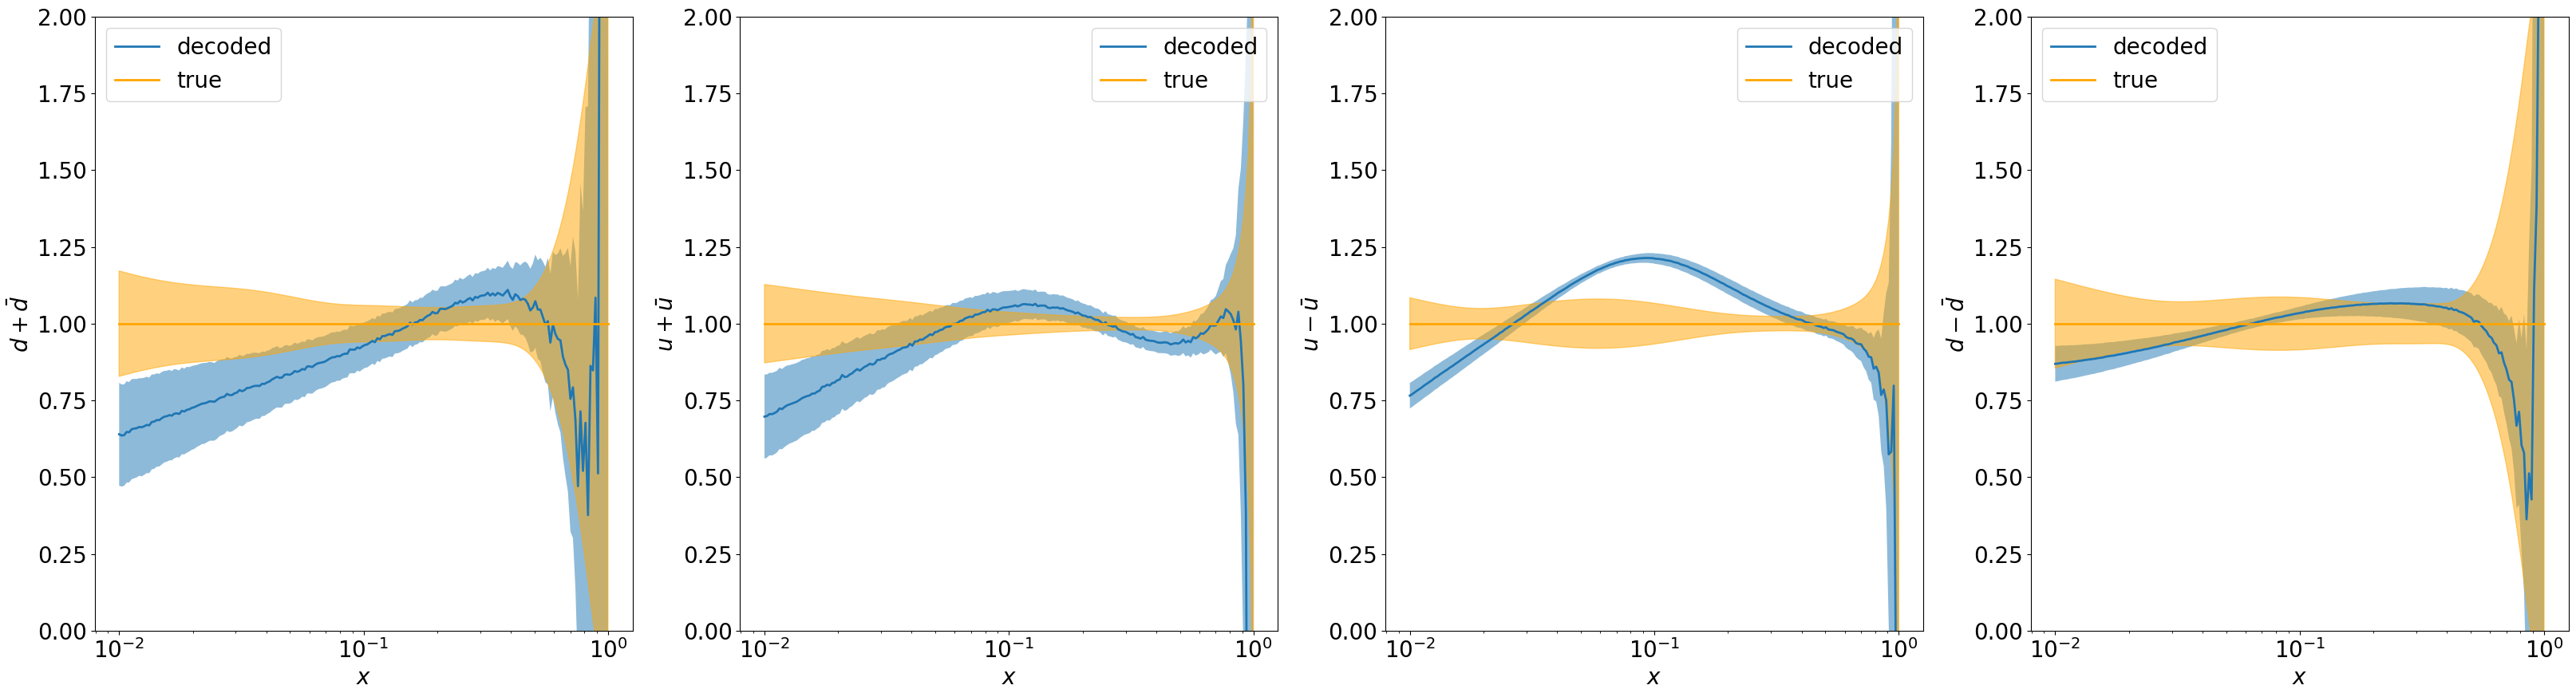

In [21]:
ct18_true_mean = [ct18_dpdb_true, ct18_upub_true, ct18_umub_true, ct18_dmdb_true]
ct18_true_err = [ct18_dplus_err, ct18_uplus_err, ct18_uminus_err, ct18_dminus_err]
fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(40,10))
for j in range(4):
    plt.subplot(1,4,j+1)
    plt.ylim(0,2)
    plt.plot(xs, ct18_pdf_mean[j]/ct18_true_mean[j],lw=2,label='decoded')
    plt.fill_between(xs, (ct18_pdf_mean[j]+ct18_pdf_std[j])/ct18_true_mean[j],
                    (ct18_pdf_mean[j]-ct18_pdf_std[j])/ct18_true_mean[j],alpha=0.5)
    plt.plot(xs,ct18_true_mean[j]/ct18_true_mean[j],color='orange',lw=2,label='true')
    plt.fill_between(xs,(ct18_true_mean[j]+ct18_true_err[j])/ct18_true_mean[j],
                     (ct18_true_mean[j]-ct18_true_err[j])/ct18_true_mean[j],color='orange',alpha=0.5)
    if j == 0:
        plt.ylabel(r'$d+\bar{d}$',fontsize=20)
    elif j == 1:
        plt.ylabel(r'$u+\bar{u}$',fontsize=20)
    elif j == 2:
        plt.ylabel(r'$u-\bar{u}$',fontsize=20)
    elif j == 3:
        plt.ylabel(r'$d-\bar{d}$',fontsize=20)
    plt.xscale('log')
    plt.xlabel(r'$x$',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='best',fontsize=20)


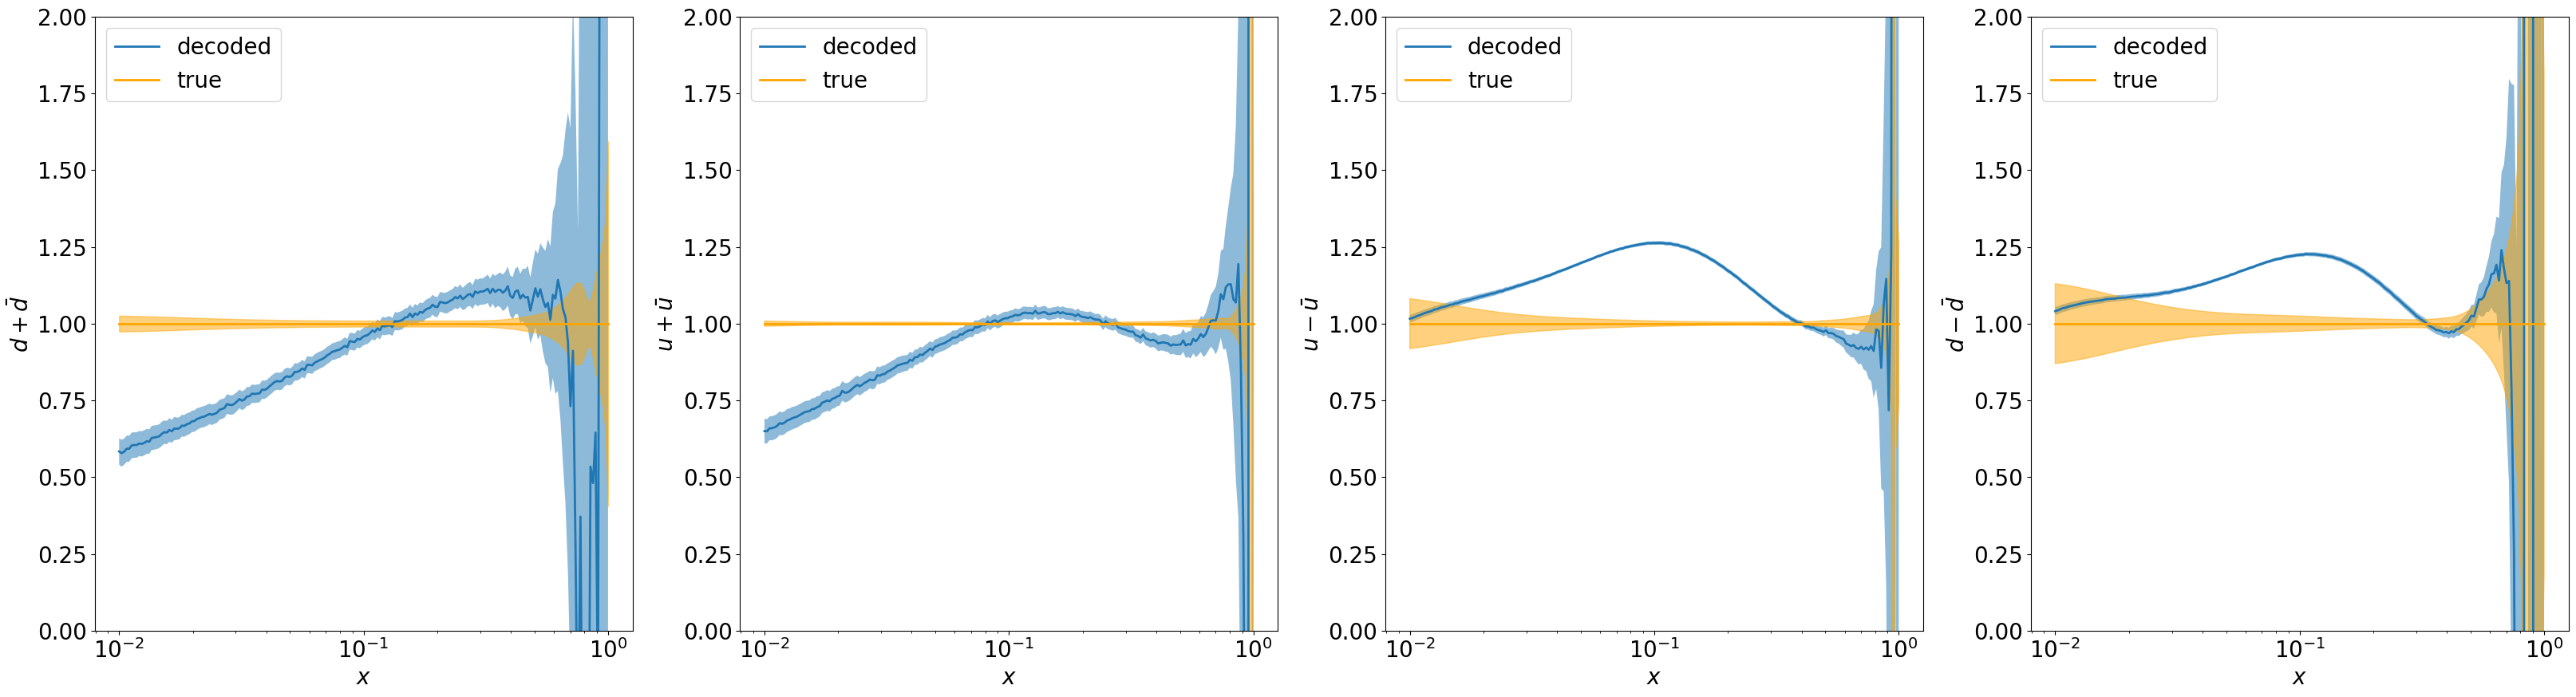

In [22]:
nnpdf40_true_mean = [nnpdf40_dpdb_true, nnpdf40_upub_true, nnpdf40_umub_true, nnpdf40_dmdb_true]
nnpdf40_true_err = [nnpdf40_dplus_err, nnpdf40_uplus_err, nnpdf40_uminus_err, nnpdf40_dminus_err]
fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(40,10))
for j in range(4):
    plt.subplot(1,4,j+1)
    plt.ylim(0,2)
    plt.plot(xs, nnpdf40_pdf_mean[j]/nnpdf40_true_mean[j],lw=2,label='decoded')
    plt.fill_between(xs, (nnpdf40_pdf_mean[j]+nnpdf40_pdf_std[j])/nnpdf40_true_mean[j],
                    (nnpdf40_pdf_mean[j]-nnpdf40_pdf_std[j])/nnpdf40_true_mean[j],alpha=0.5)
    plt.plot(xs,nnpdf40_true_mean[j]/nnpdf40_true_mean[j],color='orange',lw=2,label='true')
    plt.fill_between(xs,(nnpdf40_true_mean[j]+nnpdf40_true_err[j])/nnpdf40_true_mean[j],
                     (nnpdf40_true_mean[j]-nnpdf40_true_err[j])/nnpdf40_true_mean[j],color='orange',alpha=0.5)
    if j == 0:
        plt.ylabel(r'$d+\bar{d}$',fontsize=20)
    elif j == 1:
        plt.ylabel(r'$u+\bar{u}$',fontsize=20)
    elif j == 2:
        plt.ylabel(r'$u-\bar{u}$',fontsize=20)
    elif j == 3:
        plt.ylabel(r'$d-\bar{d}$',fontsize=20)
    plt.xscale('log')
    plt.xlabel(r'$x$',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='best',fontsize=20)

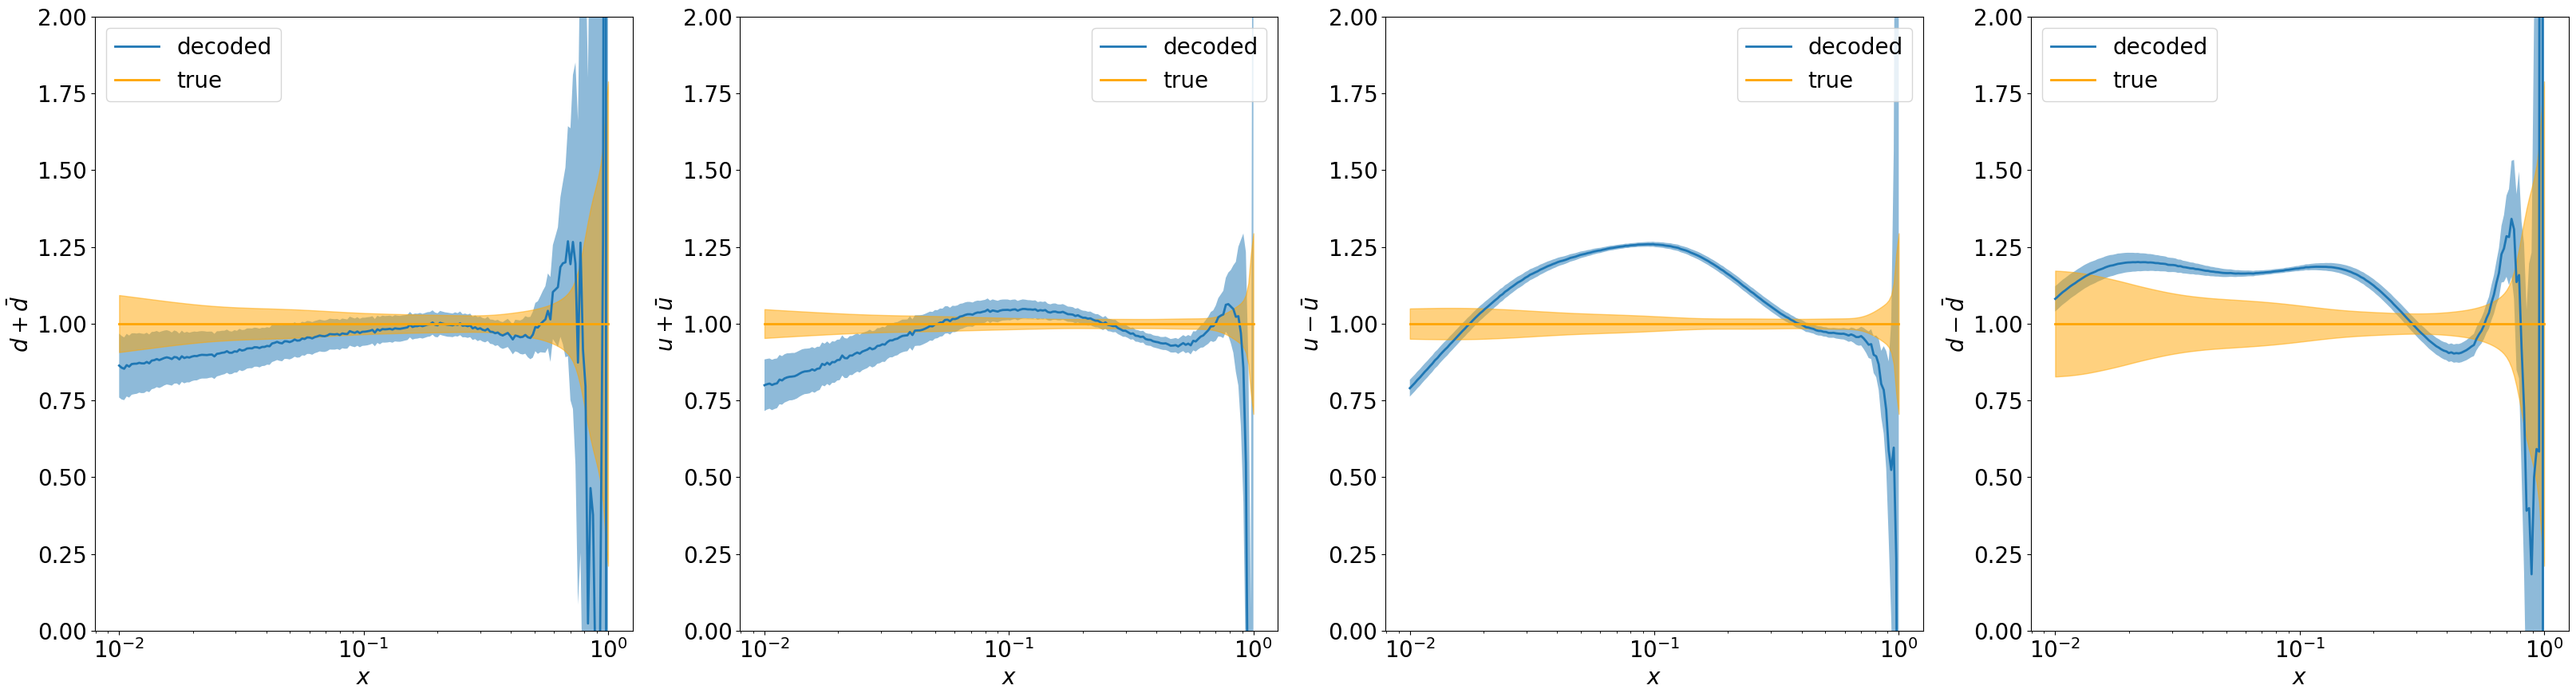

In [23]:
msht20_true_mean = [msht20_dpdb_true, msht20_upub_true, msht20_umub_true, msht20_dmdb_true]
msht20_true_err = [msht20_dplus_err, msht20_uplus_err, msht20_uminus_err, msht20_dminus_err]
fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(40,10))
for j in range(4):
    plt.subplot(1,4,j+1)
    plt.ylim(0,2)
    plt.plot(xs, msht20_pdf_mean[j]/msht20_true_mean[j],lw=2,label='decoded')
    plt.fill_between(xs, (msht20_pdf_mean[j]+msht20_pdf_std[j])/msht20_true_mean[j],
                    (msht20_pdf_mean[j]-msht20_pdf_std[j])/msht20_true_mean[j],alpha=0.5)
    plt.plot(xs,msht20_true_mean[j]/msht20_true_mean[j],color='orange',lw=2,label='true')
    plt.fill_between(xs,(msht20_true_mean[j]+msht20_true_err[j])/msht20_true_mean[j],
                     (msht20_true_mean[j]-msht20_true_err[j])/msht20_true_mean[j],color='orange',alpha=0.5)
    if j == 0:
        plt.ylabel(r'$d+\bar{d}$',fontsize=20)
    elif j == 1:
        plt.ylabel(r'$u+\bar{u}$',fontsize=20)
    elif j == 2:
        plt.ylabel(r'$u-\bar{u}$',fontsize=20)
    elif j == 3:
        plt.ylabel(r'$d-\bar{d}$',fontsize=20)
    plt.xscale('log')
    plt.xlabel(r'$x$',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='best',fontsize=20)